# How does bike-sharing service substitute for subway transit? A geospatial perspective in New York City

*Jiaxuan Tang and Muwen (Wen) He, Final project for CRP5680*

In [352]:
import os
import pandas as pd
import geopandas as gpd
import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
import contextily as ctx
from datetime import datetime
import time
import numpy as np
from shapely import geometry
from pysal.lib import weights
from pysal.explore import esda
from pysal.model import spreg
from libpysal.weights import KNN

## Abstract

共享自行车服务长久以来被认为是地铁等公共交通的互补品，用以补充所谓“最后一公里”。但实际的经验表明，在公共交通高度发达的城市中，共享自行车服务也可能作为替代地铁等出行方式的另一种选择。本文基于纽约市2022年9月的Citibike订单数据和MTA转门数据进行分析，通过一个多级别筛选模型识别Citibike订单中与地铁具有替代效应的订单所占的比例作为替代指数，以衡量全市范围（Citibike服务范围）内共享单车对地铁替代率。在时间层面上，本文计算了共享单车替代率在一天24小时之内的分布。在空间层面上，本文识别了替代率在纽约市不同地区的分布情况，并同归包含空间因素的回归模型探讨了影响替代率的社会经济因素。

结果表明，

**Key Words:**

## Primary Question

1. Is there a complementary relationship or a substitution relationship between bike-sharing and subway transit in NYC?
2. If so, on a geographical scale, what characteristics of the neighborhood will influence this relationship?

## 1. Inrtoduction and Background
从文献里洗稿？https://www.sciencedirect.com/science/article/pii/S0966692319304934?dgcid=coauthor#s0060
加上点之前做的背景研究

## 2. Data and Methodology


### 2.1 Methods



<img src="Image/1-s2.0-S0966692319304934-gr2.jpg" alt="drawing" width="600" style="display: block; margin: 0 auto"/>
</figure>

### 2.2 Study Area
研究区域是纽约市，根据citibike服务范围进一步限制
我们进一步将研究区域划分成渔网，并且赋予PLUTO数据，以便后续使用


#### 2.2.1 Deciding the Study Area Using CitiBike Docking Service Area
Here we have two steps:
1. Generate a list of active docks of the month using the citibike operating data.
2. Create a buffer of walking distance around each dock showcasing the service area.

In [186]:
### Read the citibike usage data of Sep 2022
### more information: https://citibikenyc.com/system-data 
df = pd.read_csv('Data/Citibike/Citibike_2022_Sep_RAW/202209-citibike-tripdata.csv',low_memory=False)

In [187]:
### Take a look at the columns
df.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual'],
      dtype='object')

In [188]:
### This section is to find locations of all citibike docks. The locations are to draw buffers for further analysis.
### We will use start locations since we find some of the end locations be in New Jersey (the start location shall cover all the active docks)

### drop unnecessary columns
### drop NaNs
start = df.drop(columns=['ride_id', 'rideable_type','started_at', 
                          'ended_at','end_station_name','end_station_id',
                          'end_lat', 'end_lng', 'member_casual']).dropna()

In [189]:
### Rename the columns making it easier to read
start = start.rename(columns = {'start_station_name':"station_name",
                                'start_station_id':"station_id",
                                'start_lat':"Latitude",
                                'start_lng':"Longitude"})
                                
start.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3507123 entries, 0 to 3507122
Data columns (total 4 columns):
 #   Column        Dtype  
---  ------        -----  
 0   station_name  object 
 1   station_id    object 
 2   Latitude      float64
 3   Longitude     float64
dtypes: float64(2), object(2)
memory usage: 107.0+ MB


In [190]:
### Drop duplicated stations for shorter responding time
citi_stations = start.drop_duplicates('station_name')
citi_stations

,station_name,station_id,Latitude,Longitude
0,Henry St & Degraw St,4380.08,40.684736,-73.999088
1,6 Ave & W 34 St,6364.10,40.749640,-73.988050
3,48 St & 5 Ave,3202.06,40.646351,-74.009271
4,Steinway St & Ditmars Blvd,7074.01,40.772621,-73.906240
5,1 Ave & E 62 St,6753.08,40.761305,-73.960684
...,...,...,...,...
1792531,46 St & 7 Ave,3117.05,40.644791,-74.003776
1792619,76 St & 21 Ave,7032.02,40.770234,-73.893697
1837802,Decatur Ave & E 197 St,8597.01,40.865823,-73.887657
1867320,Boerum Pl\t& Pacific St,4488.09,40.688489,-73.991160


In [191]:
### Turn the citibike data into geodata frame, then re-project it to PCS EPSG = 2263 (NAD83 / New York Long Island (ftUS))
citi_stations_geom = gpd.GeoDataFrame(citi_stations, 
                               geometry=gpd.points_from_xy(citi_stations.Longitude, citi_stations.Latitude), 
                               crs="EPSG:4326")
citi_stations_geom = citi_stations_geom.to_crs(epsg=2263)

In [8]:
### Make the geometries
### Since we used 1320 feet for walk distance (1/4 mile)
buffer_geom = citi_stations_geom['geometry'].buffer(1320)

### Second, we already know the CRS
### This the same as the CRS of public housing data 
buffer_crs = citi_stations_geom.crs

### Now, let's put it all together using the GeoDataFrame constructor
buffer = gpd.GeoDataFrame(citi_stations_geom.copy(), crs=buffer_crs, geometry=buffer_geom)

<AxesSubplot: >

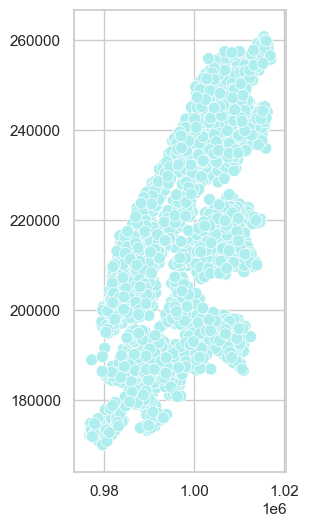

In [9]:
### Plot the buffer to eyeball it
buffer.plot(figsize=(6,6),
            facecolor = "paleturquoise", 
            edgecolor = "white",
            lw = 0.5)

<AxesSubplot: >

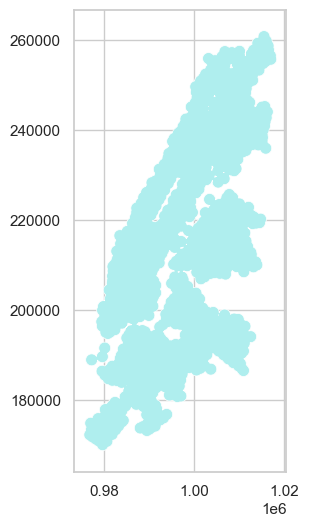

In [10]:
### Dissolve the buffer to one multipolygon 
buffer_dis = buffer.dissolve().drop(columns=['station_name', 'station_id', 'Latitude','Longitude'])

### View the resulting geodataframe
buffer_dis.plot(figsize=(6,6),
            facecolor = "paleturquoise", 
            edgecolor = "white",
            lw = 0.5)

#### 2.2.2 Create a Fishnet And Assign PLUTO Data For Future Steps

##### a. Create the Fishnet
Here we have two steps:
1. Create a fishnet accourding to the max longitute and max lagitute of Citibike doce service area.
2. Filter the fishnet to keep only area intersects to the Citibike Doce Service Area.

In [11]:
### Create a fishnet

### Get the extent of the geom
total_bounds = buffer.total_bounds
 
### Get minX, minY, maxX, maxY
minX, minY, maxX, maxY = total_bounds
 
### Create a fishnet
x, y = (minX, minY)
geom_array = []
 
    # Polygon Size
square_size = 1320
while y <= maxY:
    while x <= maxX:
        geom = geometry.Polygon([(x,y), (x, y+square_size), (x+square_size, y+square_size), (x+square_size, y), (x, y)])
        geom_array.append(geom)
        x += square_size
    x = minX
    y += square_size
 
fishnet = gpd.GeoDataFrame(geom_array, columns=['geometry']).set_crs('EPSG:2263')

<AxesSubplot: >

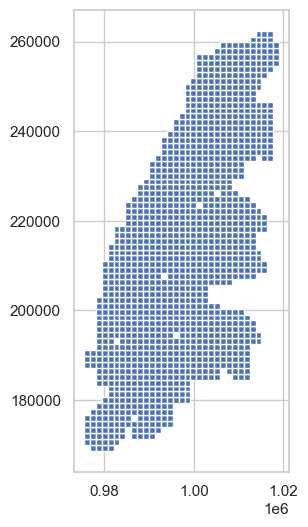

In [12]:
### Spatial join the buffer to fishnet
### We want to only keep grids that intersect to citibike service area
fishnet_crop = gpd.sjoin(fishnet, 
                         buffer, 
                         how="left", 
                         op='intersects')

### drop NaN and keep one grid at a location
fishnet_crop = fishnet_crop.dropna().drop_duplicates('geometry')

### take a look
fishnet_crop.plot(figsize=(6,6))

In [13]:
### Drop unnecessary columns for future analysis
fishnet_crop = fishnet_crop.drop(columns=['index_right','station_name', 'station_id', 'Latitude', 'Longitude'])
fishnet_crop.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1307 entries, 1 to 2341
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  1307 non-null   geometry
dtypes: geometry(1)
memory usage: 20.4 KB


##### b. Assign Lot Information from PLUTO
Two Steps:
1. Import MapPLUTO data that contains extensive land use and geographic data at the tax lot level. More information can be found at: https://www.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page.
2. Spatial join MapPLUTO to fishnet.

In [14]:
### Read the MapPLUTO data
pluto = gpd.read_file('Data/PLUTO/nyc_mappluto_22v2_arc_shp.zip')

In [15]:
### Drop unnecessary columns for shorter responding time
pluto_clean = pluto.drop(columns=['Borough', 'Block', 'Lot', 'CD', 'BCT2020', 'BCTCB2020', 'CT2010',
                           'CB2010', 'SchoolDist', 'Council', 'ZipCode', 'FireComp', 'PolicePrct',
                           'HealthCent', 'HealthArea', 'Sanitboro', 'SanitDistr', 'SanitSub',
                           'Address', 'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4',
                           'Overlay1', 'Overlay2', 'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight',
                           'SplitZone', 'BldgClass', 'LandUse', 'Easements', 'OwnerType',
                           'OwnerName', 'AreaSource', 'BldgFront', 'BldgDepth', 'Ext', 'ProxCode',
                           'IrrLotCode', 'LotType', 'BsmtCode','YearBuilt', 'YearAlter1','LotFront','LotDepth', 
                           'YearAlter2', 'HistDist', 'Landmark', 'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'BoroCode',
                           'BBL', 'CondoNo', 'Tract2010', 'XCoord', 'YCoord', 'ZoneMap', 'ZMCode',
                           'Sanborn', 'TaxMap', 'EDesigNum', 'APPBBL', 'APPDate', 'PLUTOMapID',
                           'FIRM07_FLA', 'PFIRM15_FL', 'Version', 'DCPEdited', 'Notes', 'Shape_Leng', 'Shape_Area'])

In [16]:
### Calculate for the centroid
### We want to use centroids as reference to assign lots to each grid 
pluto_clean['centroid'] = pluto_clean.centroid

### Make sure we are using crs 2263
pluto_clean.crs

<Derived Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [17]:
### Use the calculated centroid point as geometry
pluto_clean = pluto_clean.drop(columns='geometry').rename(columns={'centroid':"geometry"})

In [18]:
### Spatial join mapPLUTO data to fishnet
soci = gpd.sjoin(fishnet_crop, 
                 pluto_clean, 
                 how="left", 
                 op='contains')
soci.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 207926 entries, 1 to 2341
Data columns (total 21 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   geometry     207926 non-null  geometry
 1   index_right  207817 non-null  float64 
 2   LotArea      207817 non-null  float64 
 3   BldgArea     207817 non-null  float64 
 4   ComArea      207817 non-null  float64 
 5   ResArea      207817 non-null  float64 
 6   OfficeArea   207817 non-null  float64 
 7   RetailArea   207817 non-null  float64 
 8   GarageArea   207817 non-null  float64 
 9   StrgeArea    207817 non-null  float64 
 10  FactryArea   207817 non-null  float64 
 11  OtherArea    207817 non-null  float64 
 12  NumBldgs     207817 non-null  float64 
 13  NumFloors    207817 non-null  float64 
 14  UnitsRes     207817 non-null  float64 
 15  UnitsTotal   207817 non-null  float64 
 16  AssessLand   207817 non-null  float64 
 17  AssessTot    207817 non-null  float64 
 18

In [19]:
### Accouding to index, which represents to each grid in the fishnet
### Sum up each type of areas, building numbers, number of floors, 
### Number fo uites, assess and exempt for future analysis
soci['id'] = soci.index
soci_sum = soci.groupby('id')['LotArea', 'BldgArea', 'ComArea', 'ResArea',
                            'OfficeArea', 'RetailArea', 'GarageArea', 'StrgeArea', 
                            'FactryArea','OtherArea', 'NumBldgs', 'NumFloors', 
                            'UnitsRes', 'UnitsTotal','AssessLand', 'AssessTot', 'ExemptTot'].sum()
soci_sum.head(3)

,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,GarageArea,StrgeArea,FactryArea,OtherArea,NumBldgs,NumFloors,UnitsRes,UnitsTotal,AssessLand,AssessTot,ExemptTot
id,,,,,,,,,,,,,,,,,
1,1146344.0,1936003.0,268741.0,1502615.0,105768.0,50741.0,0.0,0.0,0.0,112232.0,423.0,932.00,1622.0,1753.0,14948236.0,83827602.0,10628703.0
2,1190884.0,1714462.0,307504.0,1304381.0,35180.0,115073.0,0.0,0.0,0.0,156275.0,582.0,1034.33,1359.0,1472.0,12682487.0,87064026.0,10102326.0
3,805486.0,798611.0,90167.0,696324.0,6973.0,48445.0,15641.0,0.0,16900.0,0.0,351.0,564.00,754.0,794.0,9343800.0,43618620.0,3698208.0


In [271]:
### Join the summed mapPLUTO data back to fishnet
soci_final = fishnet_crop.merge(soci_sum,
                                left_index=True,
                                right_on='id',how='left')
                                
soci_final.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1307 entries, 1 to 2341
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   geometry    1307 non-null   geometry
 1   LotArea     1307 non-null   float64 
 2   BldgArea    1307 non-null   float64 
 3   ComArea     1307 non-null   float64 
 4   ResArea     1307 non-null   float64 
 5   OfficeArea  1307 non-null   float64 
 6   RetailArea  1307 non-null   float64 
 7   GarageArea  1307 non-null   float64 
 8   StrgeArea   1307 non-null   float64 
 9   FactryArea  1307 non-null   float64 
 10  OtherArea   1307 non-null   float64 
 11  NumBldgs    1307 non-null   float64 
 12  NumFloors   1307 non-null   float64 
 13  UnitsRes    1307 non-null   float64 
 14  UnitsTotal  1307 non-null   float64 
 15  AssessLand  1307 non-null   float64 
 16  AssessTot   1307 non-null   float64 
 17  ExemptTot   1307 non-null   float64 
dtypes: float64(17), geometry(1)
memory usage

### 2.3 Data Wrangling


#### 2.3.1 Processing MTA Turnstile Data
We use...

##### a. Importing MTA Turnstile Data

In [21]:
### We create an empty DataFrame to store the data, and combine all the csv files in the root folder as one single DataFrame
mta = pd.DataFrame(data=None)
mta_root = "Data/MTA/2022_Sep_Raw/"
for item in os.listdir(mta_root):
    if not item.startswith('.') and os.path.isfile(os.path.join(mta_root, item)):
        mta = pd.concat([mta, pd.read_csv('Data/MTA/2022_Sep_Raw/'+item)])

In [22]:
### Take a look at the data
mta.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/17/2022,00:00:00,REGULAR,7764183,2740761
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/17/2022,04:00:00,REGULAR,7764199,2740765
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/17/2022,08:00:00,REGULAR,7764207,2740786
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/17/2022,12:00:00,REGULAR,7764258,2740854
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/17/2022,16:00:00,REGULAR,7764341,2740900


In [23]:
### Reanme the columns to prevent potential bugs
mta.columns = ['C/A', 'Unit', 'Scp', 'Station', 'Linename', 'Division', 'Date', 'Time', 'Desc', 'Entries', 'Exits']
mta.head()

,C/A,Unit,Scp,Station,Linename,Division,Date,Time,Desc,Entries,Exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/17/2022,00:00:00,REGULAR,7764183,2740761
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/17/2022,04:00:00,REGULAR,7764199,2740765
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/17/2022,08:00:00,REGULAR,7764207,2740786
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/17/2022,12:00:00,REGULAR,7764258,2740854
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/17/2022,16:00:00,REGULAR,7764341,2740900


##### b. Data cleaning: Processing Exit/Entrance Counts and Time

In [24]:
### Define a custom function to convert date and time in string format into local-time-zone timestamp
def date_convert(date_to_convert):
     return time.mktime(datetime.strptime(date_to_convert, "%m/%d/%Y %H:%M:%S").timetuple())

In [25]:
### Extract the date and time string as dt
dt = mta['Date'] + ' ' + mta['Time']

In [26]:
### Create a new column to store the timestamp
mta['Timestamp'] = dt.apply(date_convert)

In [27]:
### Sorting records by multi-level criteria to ensure that each turnstile's records are in chronological order, and then re-index the whole dataframe to store this order
mta = mta.sort_values(by=['Station','C/A','Scp','Timestamp'],ascending=(True, True,True, True))
mta.reset_index(drop=True, inplace=True)
mta

,C/A,Unit,Scp,Station,Linename,Division,Date,Time,Desc,Entries,Exits,Timestamp
0,H007,R248,00-00-00,1 AV,L,BMT,08/27/2022,00:00:00,REGULAR,15825817,18930698,1.661573e+09
1,H007,R248,00-00-00,1 AV,L,BMT,08/27/2022,04:00:00,REGULAR,15825825,18930866,1.661587e+09
2,H007,R248,00-00-00,1 AV,L,BMT,08/27/2022,05:02:22,REGULAR,15825827,18930875,1.661591e+09
3,H007,R248,00-00-00,1 AV,L,BMT,08/27/2022,05:03:42,REGULAR,15825827,18930875,1.661591e+09
4,H007,R248,00-00-00,1 AV,L,BMT,08/27/2022,05:05:04,REGULAR,15825827,18930875,1.661591e+09
...,...,...,...,...,...,...,...,...,...,...,...,...
1057503,R419,R326,00-05-01,ZEREGA AV,6,IRT,09/30/2022,05:00:00,REGULAR,39,289,1.664528e+09
1057504,R419,R326,00-05-01,ZEREGA AV,6,IRT,09/30/2022,09:00:00,REGULAR,39,289,1.664543e+09
1057505,R419,R326,00-05-01,ZEREGA AV,6,IRT,09/30/2022,13:00:00,REGULAR,39,289,1.664557e+09
1057506,R419,R326,00-05-01,ZEREGA AV,6,IRT,09/30/2022,17:00:00,REGULAR,39,289,1.664572e+09


In [28]:
'''
Use a single-tier loop to calculate the turnstile entry/exit numbers from the original cumulative records.
As we have already re-indexed the records, we can do the following thing in the loop:
If the one row matches the 'Station' , 'C/A' and 'Scp' column of its above row, then we can say it's from the same turnstile,
    therefore we subtract the number of the previous row from the number of that row to get the entery/exit counts in that time interval (four hours).
If any one of the four columns mentioned above doesn't match, that means this row is a starting row belonging to a new turnstile,
    therefore we do not do the calculation (we will do it later),
    and record this row's index in 'start_index' to help us find these starting rows more easily in the following steps.
Therefore, we get Enties_n representing the entries made between the previous timestamp and this timstamp, same for Exits_n.
This will cause a problem which we will solve later.
'''
start_index = np.array([0])
for i in mta.index[1:len(mta.index)]:
    if((mta.loc[i,'Station']==mta.loc[i-1,'Station']) & (mta.loc[i,'C/A']==mta.loc[i-1,'C/A']) & (mta.loc[i,'Scp']==mta.loc[i-1,'Scp'])):
        mta.loc[i,'Entries_n'] = mta.loc[i,'Entries'] - mta.loc[i-1,'Entries']
        mta.loc[i,'Exits_n'] = mta.loc[i,'Exits'] - mta.loc[i-1,'Exits']
    else:
        start_index = np.append(start_index, i)

In [29]:
### One more steps for the starting rows: we let them be 0, because we don't have the data in their time interval
### (this acually doesn't matter since the records starts in late August and we will drop these rows to keep jest the record in September)
for i in start_index:
    mta.loc[i,'Entries_n'] = 0
    mta.loc[i,'Exits_n'] = 0
mta

,C/A,Unit,Scp,Station,Linename,Division,Date,Time,Desc,Entries,Exits,Timestamp,Entries_n,Exits_n
0,H007,R248,00-00-00,1 AV,L,BMT,08/27/2022,00:00:00,REGULAR,15825817,18930698,1.661573e+09,0.0,0.0
1,H007,R248,00-00-00,1 AV,L,BMT,08/27/2022,04:00:00,REGULAR,15825825,18930866,1.661587e+09,8.0,168.0
2,H007,R248,00-00-00,1 AV,L,BMT,08/27/2022,05:02:22,REGULAR,15825827,18930875,1.661591e+09,2.0,9.0
3,H007,R248,00-00-00,1 AV,L,BMT,08/27/2022,05:03:42,REGULAR,15825827,18930875,1.661591e+09,0.0,0.0
4,H007,R248,00-00-00,1 AV,L,BMT,08/27/2022,05:05:04,REGULAR,15825827,18930875,1.661591e+09,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057503,R419,R326,00-05-01,ZEREGA AV,6,IRT,09/30/2022,05:00:00,REGULAR,39,289,1.664528e+09,0.0,0.0
1057504,R419,R326,00-05-01,ZEREGA AV,6,IRT,09/30/2022,09:00:00,REGULAR,39,289,1.664543e+09,0.0,0.0
1057505,R419,R326,00-05-01,ZEREGA AV,6,IRT,09/30/2022,13:00:00,REGULAR,39,289,1.664557e+09,0.0,0.0
1057506,R419,R326,00-05-01,ZEREGA AV,6,IRT,09/30/2022,17:00:00,REGULAR,39,289,1.664572e+09,0.0,0.0


In [30]:
### Get the absolute number of all the entry/exit records, since some turnstiles will downcount 1 for everytime usage (the opposite to most of the others)
mta['Entries_n'] = abs(mta['Entries_n'])
mta['Exits_n'] = abs(mta['Exits_n'])

In [31]:
### Remove extreme values, these values appear because of hardware failure or limitation.
### We set the threshold to 10000 in four hours according to Chirs Wong: https://medium.com/qri-io/taming-the-mtas-unruly-turnstile-data-c945f5f96ba0
mta = mta[(mta['Entries_n']<=10000) & (mta['Exits_n']<=10000)]

In [32]:
### Trick: Export the mta data to a CSV file. You can re-read it in the cell below if the data wrangling steps take too long to run!
mta.to_csv('Data/MTA/MTA_ALL_RAW.csv',index=False)

In [33]:
### Read the exported file (as if nothing has happened!)
mta = pd.read_csv('Data/MTA/MTA_ALL_RAW.csv')

In [34]:
### Divide 4-hour intervals into 4 one-hour intervels.
### CAUTION: To reduce the computational pressure, here we make them in to four different DataFrames. We will merge them in the very last step.
### Here, time_interval = 3600 equals to one hour. We also divide the counts in every four-hour interval evenly into the four one-hour intervals.
### This is meaningful because although all the original intervals are four hours, but they are not divided with the same time point (to avoid huge data flow to the system).
time_interval = 3600
mta.loc[:,'Exits_n'] = mta.loc[:,'Exits_n']/4
mta.loc[:,'Entries_n'] = mta.loc[:,'Entries_n']/4

mta_1 = mta.copy(deep=True)
mta_2 = mta.copy(deep=True)
mta_3 = mta.copy(deep=True)
mta_1['Timestamp'] = mta_1['Timestamp'] - time_interval * 1
mta_2['Timestamp'] = mta_2['Timestamp'] - time_interval * 2
mta_3['Timestamp'] = mta_3['Timestamp'] - time_interval * 3

In [35]:
### Drop Weekends: we only study the weekdays
mta = mta[(mta['Timestamp'].apply(lambda x: time.localtime(x).tm_wday)!=5) & (mta['Timestamp'].apply(lambda x: time.localtime(x).tm_wday)!=6)]
mta_1 = mta_1[(mta_1['Timestamp'].apply(lambda x: time.localtime(x).tm_wday)!=5) & (mta_1['Timestamp'].apply(lambda x: time.localtime(x).tm_wday)!=6)]
mta_2 = mta_2[(mta_2['Timestamp'].apply(lambda x: time.localtime(x).tm_wday)!=5) & (mta_2['Timestamp'].apply(lambda x: time.localtime(x).tm_wday)!=6)]
mta_3 = mta_3[(mta_3['Timestamp'].apply(lambda x: time.localtime(x).tm_wday)!=5) & (mta_3['Timestamp'].apply(lambda x: time.localtime(x).tm_wday)!=6)]

In [36]:
### Drop non-September travels
mta = mta[(mta['Timestamp'].apply(lambda x: time.localtime(x).tm_mon)!=8) & (mta['Timestamp'].apply(lambda x: time.localtime(x).tm_mon)!=10)]
mta_1 = mta_1[(mta_1['Timestamp'].apply(lambda x: time.localtime(x).tm_mon)!=8) & (mta_1['Timestamp'].apply(lambda x: time.localtime(x).tm_mon)!=10)]
mta_2 = mta_2[(mta_2['Timestamp'].apply(lambda x: time.localtime(x).tm_mon)!=8) & (mta_2['Timestamp'].apply(lambda x: time.localtime(x).tm_mon)!=10)]
mta_3 = mta_3[(mta_3['Timestamp'].apply(lambda x: time.localtime(x).tm_mon)!=8) & (mta_3['Timestamp'].apply(lambda x: time.localtime(x).tm_mon)!=10)]

In [37]:
### Round time into full hours: some MTA records are not divided at the full hour, so we have to choose the nearest full hour to make an approximation
def get_hour(timestamp):
    return time.localtime(timestamp).tm_hour + round(time.localtime(timestamp).tm_min/60)

In [38]:
### Round time into full hours
mta['Time_in_a_day'] = mta['Timestamp'].apply(get_hour)
mta_1['Time_in_a_day'] = mta_1['Timestamp'].apply(get_hour)
mta_2['Time_in_a_day'] = mta_2['Timestamp'].apply(get_hour)
mta_3['Time_in_a_day'] = mta_3['Timestamp'].apply(get_hour)

In [39]:
### And to prevent two expressions for 00:00, we set all the 24:00 to 00:00
mta.loc[mta['Time_in_a_day']==24,'Time_in_a_day'] = 0
mta_1.loc[mta_1['Time_in_a_day']==24,'Time_in_a_day'] = 0
mta_2.loc[mta_2['Time_in_a_day']==24,'Time_in_a_day'] = 0
mta_3.loc[mta_3['Time_in_a_day']==24,'Time_in_a_day'] = 0

##### c. Compressing the Data to Station Level

In [40]:
### Create a new DataFrame to store the station-level records, with initial value set to 0
### Here, in MTA's management system, the 'Unit' is the unique code for different station. We use it as the ID of the stations.
### As we mentioned, Enties_i means the entries made between (i-1):00 and i:00, same for the Exits_i. We will fix this later.
mta_compressed = pd.DataFrame(data=None)
mta_compressed['Unit'] = mta['Unit'].unique()
for j in range (0,24):
    mta_compressed.loc[:,'Entries_'+str(j)] = 0
    mta_compressed.loc[:,'Exits_'+str(j)] = 0
mta_compressed

,Unit,Entries_0,Exits_0,Entries_1,Exits_1,Entries_2,Exits_2,Entries_3,Exits_3,Entries_4,...,Entries_19,Exits_19,Entries_20,Exits_20,Entries_21,Exits_21,Entries_22,Exits_22,Entries_23,Exits_23
0,R248,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,R314,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,R191,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,R180,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,R208,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,R201,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
466,R052,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
467,R305,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
468,R301,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
### In the next four cells (since we divide the data into four parts), we will calculate the station-level entries/exits.
### CAUTION: Each cell will take 7 miniutes to run!
for i in mta.index:
    j = mta.loc[i,'Time_in_a_day']
    mta_compressed.loc[mta_compressed['Unit'] == mta.loc[i,'Unit'],'Entries_'+str(j)] += mta.loc[i,'Entries_n']
    mta_compressed.loc[mta_compressed['Unit'] == mta.loc[i,'Unit'],'Exits_'+str(j)] += mta.loc[i,'Exits_n']

In [42]:
for i in mta_1.index:
    j = mta_1.loc[i,'Time_in_a_day']
    mta_compressed.loc[mta_compressed['Unit'] == mta_1.loc[i,'Unit'],'Entries_'+str(j)] += mta_1.loc[i,'Entries_n']
    mta_compressed.loc[mta_compressed['Unit'] == mta_1.loc[i,'Unit'],'Exits_'+str(j)] += mta_1.loc[i,'Exits_n']

In [43]:
for i in mta_2.index:
    j = mta_2.loc[i,'Time_in_a_day']
    mta_compressed.loc[mta_compressed['Unit'] == mta_2.loc[i,'Unit'],'Entries_'+str(j)] += mta_2.loc[i,'Entries_n']
    mta_compressed.loc[mta_compressed['Unit'] == mta_2.loc[i,'Unit'],'Exits_'+str(j)] += mta_2.loc[i,'Exits_n']

In [44]:
for i in mta_3.index:
    j = mta_3.loc[i,'Time_in_a_day']
    mta_compressed.loc[mta_compressed['Unit'] == mta_3.loc[i,'Unit'],'Entries_'+str(j)] += mta_3.loc[i,'Entries_n']
    mta_compressed.loc[mta_compressed['Unit'] == mta_3.loc[i,'Unit'],'Exits_'+str(j)] += mta_3.loc[i,'Exits_n']

In [45]:
### Since we cumulated all the data in 30 DAYS of September, we need to calculate the average of each ONE hour in each ONE day
mta_compressed.loc[:,'Entries_0':'Exits_23'] = mta_compressed.loc[:,'Entries_0':'Exits_23']/30

In [46]:
### As we mentioned, Enties_i means the entries made between (i-1):00 and i:00, same for the Exits_i. Here we will fix this problem, to make i represent i:00 to (i+1):00
for i in range(0,24):
    mta_compressed = mta_compressed.rename(columns={'Entries_'+str(i):'entries_'+str(i-1), 'Exits_'+str(i):'exits_'+str(i-1)})
mta_compressed = mta_compressed.rename(columns={'entries_-1':'entries_23', 'exits_-1':'exits_23'})
mta_compressed

,Unit,entries_23,exits_23,entries_0,exits_0,entries_1,exits_1,entries_2,exits_2,entries_3,...,entries_18,exits_18,entries_19,exits_19,entries_20,exits_20,entries_21,exits_21,entries_22,exits_22
0,R248,166.275000,488.075000,22.391667,80.433333,22.391667,80.433333,22.391667,80.433333,22.391667,...,474.875000,986.383333,474.875000,986.383333,176.175000,518.625000,176.175000,518.625000,176.175000,518.625000
1,R314,10.841667,62.558333,10.841667,62.558333,2.750000,10.350000,2.750000,10.350000,2.750000,...,69.791667,152.575000,69.791667,152.575000,69.791667,152.575000,11.641667,63.600000,11.641667,63.600000
2,R191,53.716667,127.108333,53.716667,127.108333,4.866667,15.016667,4.866667,15.016667,4.866667,...,222.033333,282.541667,222.033333,282.541667,222.033333,282.541667,55.716667,130.016667,55.716667,130.016667
3,R180,43.300000,160.833333,43.300000,160.833333,7.800000,25.383333,7.800000,25.383333,7.800000,...,218.175000,395.916667,218.175000,395.916667,218.175000,395.916667,44.991667,162.558333,44.991667,162.558333
4,R208,98.000000,482.483333,22.950000,158.475000,22.950000,158.475000,22.950000,158.475000,22.950000,...,286.141667,1156.733333,286.141667,1156.733333,98.583333,482.650000,98.583333,482.650000,98.583333,482.650000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,R201,46.091667,164.666667,46.091667,164.666667,17.041667,31.825000,17.041667,31.825000,17.041667,...,272.925000,621.083333,272.925000,621.083333,272.925000,621.083333,49.100000,168.850000,49.100000,168.850000
466,R052,43.666667,42.416667,9.391667,16.291667,9.391667,16.291667,9.391667,16.291667,9.391667,...,120.075000,90.116667,120.075000,90.116667,44.133333,43.100000,44.133333,43.100000,44.133333,43.100000
467,R305,44.983333,118.141667,44.983333,118.141667,4.491667,19.125000,4.491667,19.125000,4.491667,...,267.275000,348.116667,267.275000,348.116667,267.275000,348.116667,42.766667,115.158333,42.766667,115.158333
468,R301,55.775000,65.850000,55.775000,65.850000,2.983333,6.191667,2.983333,6.191667,2.983333,...,271.891667,197.100000,262.758333,191.708333,262.758333,191.708333,54.325000,68.375000,54.325000,68.375000


In [47]:
### Export: The same trick as above!
mta_compressed.to_csv('Data/MTA/MTA_COMPRESSED.csv',index=False)

In [48]:
### Read
mta_compressed = pd.read_csv('Data/MTA/MTA_COMPRESSED.csv')
mta_compressed

,Unit,entries_23,exits_23,entries_0,exits_0,entries_1,exits_1,entries_2,exits_2,entries_3,...,entries_18,exits_18,entries_19,exits_19,entries_20,exits_20,entries_21,exits_21,entries_22,exits_22
0,R248,166.275000,488.075000,22.391667,80.433333,22.391667,80.433333,22.391667,80.433333,22.391667,...,474.875000,986.383333,474.875000,986.383333,176.175000,518.625000,176.175000,518.625000,176.175000,518.625000
1,R314,10.841667,62.558333,10.841667,62.558333,2.750000,10.350000,2.750000,10.350000,2.750000,...,69.791667,152.575000,69.791667,152.575000,69.791667,152.575000,11.641667,63.600000,11.641667,63.600000
2,R191,53.716667,127.108333,53.716667,127.108333,4.866667,15.016667,4.866667,15.016667,4.866667,...,222.033333,282.541667,222.033333,282.541667,222.033333,282.541667,55.716667,130.016667,55.716667,130.016667
3,R180,43.300000,160.833333,43.300000,160.833333,7.800000,25.383333,7.800000,25.383333,7.800000,...,218.175000,395.916667,218.175000,395.916667,218.175000,395.916667,44.991667,162.558333,44.991667,162.558333
4,R208,98.000000,482.483333,22.950000,158.475000,22.950000,158.475000,22.950000,158.475000,22.950000,...,286.141667,1156.733333,286.141667,1156.733333,98.583333,482.650000,98.583333,482.650000,98.583333,482.650000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,R201,46.091667,164.666667,46.091667,164.666667,17.041667,31.825000,17.041667,31.825000,17.041667,...,272.925000,621.083333,272.925000,621.083333,272.925000,621.083333,49.100000,168.850000,49.100000,168.850000
466,R052,43.666667,42.416667,9.391667,16.291667,9.391667,16.291667,9.391667,16.291667,9.391667,...,120.075000,90.116667,120.075000,90.116667,44.133333,43.100000,44.133333,43.100000,44.133333,43.100000
467,R305,44.983333,118.141667,44.983333,118.141667,4.491667,19.125000,4.491667,19.125000,4.491667,...,267.275000,348.116667,267.275000,348.116667,267.275000,348.116667,42.766667,115.158333,42.766667,115.158333
468,R301,55.775000,65.850000,55.775000,65.850000,2.983333,6.191667,2.983333,6.191667,2.983333,...,271.891667,197.100000,262.758333,191.708333,262.758333,191.708333,54.325000,68.375000,54.325000,68.375000


##### d. Linking Geo Location to the Turnstile Data

In [49]:
### Link Stations: we travel through three spreadsheets to get the corresponding coordinates of each MTA station 
### Thanks to Chris Whong: https://medium.com/qri-io/taming-the-mtas-unruly-turnstile-data-c945f5f96ba0
### The path is: MTA Stations => 'Unit' column in mta_compressed => 'remote' column in Booth_code => 'complex_id' column in Booth_code => 'Complex ID' column in Station_data => lat and lng in Station_data
Booth_code = pd.read_csv('Data/MTA/Stations/remote_complex_lookup.csv')
Booth_code.columns = ['remote', 'booth', 'complex_id', 'station', 'line_name', 'division']
Booth_code = Booth_code.drop_duplicates(subset=['remote'])

In [50]:
mta_compressed = mta_compressed.merge(Booth_code[['remote','complex_id']], left_on='Unit', right_on='remote', how='left')

In [51]:
Station_data = pd.read_csv('Data/MTA/Stations/Stations.csv')
Station_data = Station_data.drop_duplicates(subset=['Complex ID'])

In [52]:
mta_compressed = mta_compressed.merge(Station_data[['Complex ID','GTFS Latitude','GTFS Longitude']], left_on='complex_id', right_on='Complex ID', how='left')

In [53]:
### Then we drop the records that doesn't match to any coordinate.
mta_compressed = mta_compressed[mta_compressed['GTFS Latitude'].isna()==False]
mta_compressed = mta_compressed[mta_compressed['GTFS Longitude'].isna()==False]
mta_compressed

,Unit,entries_23,exits_23,entries_0,exits_0,entries_1,exits_1,entries_2,exits_2,entries_3,...,exits_20,entries_21,exits_21,entries_22,exits_22,remote,complex_id,Complex ID,GTFS Latitude,GTFS Longitude
0,R248,166.275000,488.075000,22.391667,80.433333,22.391667,80.433333,22.391667,80.433333,22.391667,...,518.625000,176.175000,518.625000,176.175000,518.625000,R248,119.0,119.0,40.730953,-73.981628
1,R314,10.841667,62.558333,10.841667,62.558333,2.750000,10.350000,2.750000,10.350000,2.750000,...,152.575000,11.641667,63.600000,11.641667,63.600000,R314,156.0,156.0,40.796092,-73.961454
2,R191,53.716667,127.108333,53.716667,127.108333,4.866667,15.016667,4.866667,15.016667,4.866667,...,282.541667,55.716667,130.016667,55.716667,130.016667,R191,309.0,309.0,40.799446,-73.968379
3,R180,43.300000,160.833333,43.300000,160.833333,7.800000,25.383333,7.800000,25.383333,7.800000,...,395.916667,44.991667,162.558333,44.991667,162.558333,R180,395.0,395.0,40.790600,-73.947478
4,R208,98.000000,482.483333,22.950000,158.475000,22.950000,158.475000,22.950000,158.475000,22.950000,...,482.650000,98.583333,482.650000,98.583333,482.650000,R208,450.0,450.0,40.749865,-73.862700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,R201,46.091667,164.666667,46.091667,164.666667,17.041667,31.825000,17.041667,31.825000,17.041667,...,621.083333,49.100000,168.850000,49.100000,168.850000,R201,264.0,264.0,40.733106,-73.869229
466,R052,43.666667,42.416667,9.391667,16.291667,9.391667,16.291667,9.391667,16.291667,9.391667,...,43.100000,44.133333,43.100000,44.133333,43.100000,R052,378.0,378.0,40.886037,-73.878751
467,R305,44.983333,118.141667,44.983333,118.141667,4.491667,19.125000,4.491667,19.125000,4.491667,...,348.116667,42.766667,115.158333,42.766667,115.158333,R305,328.0,328.0,40.711835,-74.012188
468,R301,55.775000,65.850000,55.775000,65.850000,2.983333,6.191667,2.983333,6.191667,2.983333,...,191.708333,54.325000,68.375000,54.325000,68.375000,R301,235.0,235.0,40.701397,-73.986751


In [54]:
### Generate a new Geo DataFrame with the geometry information, then reproject into PCS EPSG = 2263 (NAD83 / New York Long Island (ftUS))
mta_compressed_geom = gpd.GeoDataFrame(mta_compressed, 
                                geometry=gpd.points_from_xy(mta_compressed['GTFS Longitude'], mta_compressed['GTFS Latitude']),
                                crs='EPSG:4326')
mta_compressed_geom = mta_compressed_geom.to_crs(2263)

<AxesSubplot: >

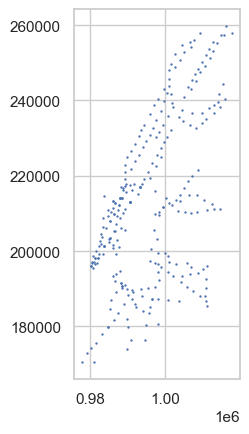

In [55]:
### Filter the stations inside the study area
mta_compressed_geom_study = gpd.sjoin(mta_compressed_geom, buffer_dis, predicate='within')
mta_compressed_geom_study.plot(markersize=0.5)

#### 2.3.2 Processing Citi Bike Data

##### a. Importing Data

In [56]:
### Read the Citi Bike records from the original CSV file
citi = pd.read_csv('Data/Citibike/Citibike_2022_Sep_RAW/202209-citibike-tripdata.csv',low_memory=False)

In [57]:
### Take a look at the data
citi.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,42B9E1161E021F66,classic_bike,2022-09-17 16:06:45,2022-09-17 16:18:03,Henry St & Degraw St,4380.08,7 Ave & Park Pl,4125.07,40.684736,-73.999088,40.677615,-73.973243,member
1,FE5FB109CA0FB68B,classic_bike,2022-09-25 14:26:25,2022-09-25 14:39:43,6 Ave & W 34 St,6364.10,W 50 St & 9 Ave,6854.05,40.749640,-73.988050,40.763605,-73.989180,member
2,D4E9E27DCE9CC556,classic_bike,2022-09-15 13:25:37,2022-09-15 13:51:35,6 Ave & W 34 St,6364.10,5 Ave & E 78 St,7161.08,40.749640,-73.988050,40.776321,-73.964274,member
3,757BFFFB009E8D21,classic_bike,2022-09-16 18:46:33,2022-09-16 18:52:42,48 St & 5 Ave,3202.06,36 St & 4 Ave,3420.01,40.646351,-74.009271,40.654144,-74.004220,member
4,4E6360AD2986736E,classic_bike,2022-09-10 09:20:56,2022-09-10 09:30:20,Steinway St & Ditmars Blvd,7074.01,Crescent St & 30 Ave,6958.06,40.772621,-73.906240,40.768692,-73.924957,member


In [58]:
### Convert the date and time in str format into timestamp
def date_convert_citi(date_to_convert):
     return time.mktime(datetime.strptime(date_to_convert, "%Y-%m-%d %H:%M:%S").timetuple())

citi['start_timestamp'] = citi['started_at'].apply(date_convert_citi)
citi['end_timestamp'] = citi['ended_at'].apply(date_convert_citi)

In [59]:
### Calculate the duration of each trip (in second)
citi['duration'] = citi['end_timestamp'] - citi['start_timestamp']

In [60]:
### Get the hour of every timestamp
### NOTICE here we have a different function from the 'get_hour' above (because here we are facing standalone records rather than counts during the intervals)
def get_hour_citi(timestamp):
    return time.localtime(timestamp).tm_hour

In [61]:
### Round time into hours,and avoid '24:00'
citi['start_time'] = citi['start_timestamp'].apply(get_hour_citi)
citi['end_time'] = citi['end_timestamp'].apply(get_hour_citi)
citi.loc[citi['start_time']==24,'start_time'] = 0
citi.loc[citi['end_time']==24,'end_time'] = 0
citi.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_timestamp,end_timestamp,duration,start_time,end_time
0,42B9E1161E021F66,classic_bike,2022-09-17 16:06:45,2022-09-17 16:18:03,Henry St & Degraw St,4380.08,7 Ave & Park Pl,4125.07,40.684736,-73.999088,40.677615,-73.973243,member,1.663445e+09,1.663446e+09,678.0,16,16
1,FE5FB109CA0FB68B,classic_bike,2022-09-25 14:26:25,2022-09-25 14:39:43,6 Ave & W 34 St,6364.10,W 50 St & 9 Ave,6854.05,40.749640,-73.988050,40.763605,-73.989180,member,1.664130e+09,1.664131e+09,798.0,14,14
2,D4E9E27DCE9CC556,classic_bike,2022-09-15 13:25:37,2022-09-15 13:51:35,6 Ave & W 34 St,6364.10,5 Ave & E 78 St,7161.08,40.749640,-73.988050,40.776321,-73.964274,member,1.663263e+09,1.663264e+09,1558.0,13,13
3,757BFFFB009E8D21,classic_bike,2022-09-16 18:46:33,2022-09-16 18:52:42,48 St & 5 Ave,3202.06,36 St & 4 Ave,3420.01,40.646351,-74.009271,40.654144,-74.004220,member,1.663368e+09,1.663369e+09,369.0,18,18
4,4E6360AD2986736E,classic_bike,2022-09-10 09:20:56,2022-09-10 09:30:20,Steinway St & Ditmars Blvd,7074.01,Crescent St & 30 Ave,6958.06,40.772621,-73.906240,40.768692,-73.924957,member,1.662816e+09,1.662817e+09,564.0,9,9


##### b. Data Cleaning: Removing Extreme Values and Weekends

(array([0., 0., 0., ..., 1., 4., 5.]),
 array([-500., -499., -498., ..., 7997., 7998., 7999.]),
 <BarContainer object of 8499 artists>)

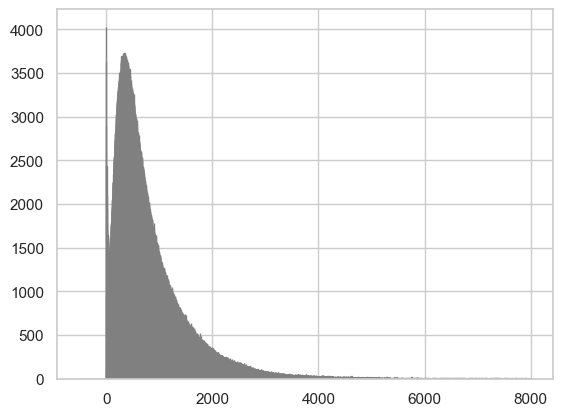

In [62]:
### Have a look at the shape of the raw data
plt.hist(citi.duration,bins=range(-500,8000),edgecolor='grey')

By the histogram above, we can tell the data has a long-tail distributation, and choose trips of which the duration lies between 1 minute (60s) and 1.5 hours (5400s) seems to be reasonable.

In [63]:
### Remove those records doesn't match the criteria
citi = citi[(citi['duration'] >= 60) & (citi['duration'] <= 5400)]

(array([0., 0., 0., ..., 0., 0., 0.]),
 array([0.000e+00, 1.000e+00, 2.000e+00, ..., 5.997e+03, 5.998e+03,
        5.999e+03]),
 <BarContainer object of 5999 artists>)

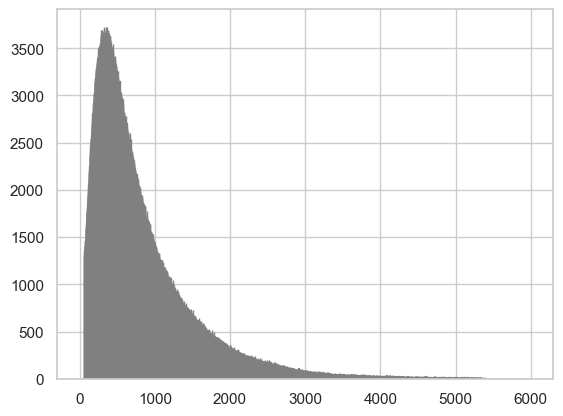

In [64]:
### Have a look at the shape of the filtered data
plt.hist(citi.duration,bins=range(0,6000),edgecolor='grey')

In [65]:
### Removing weekends
citi = citi[(citi['start_timestamp'].apply(lambda x: time.localtime(x).tm_wday)!=5) & (citi['start_timestamp'].apply(lambda x: time.localtime(x).tm_wday)!=6)]

##### c. Add Geom Data to Citi Bike Records

In [66]:
### Create the geom of start locations
citi_geom_start = gpd.GeoDataFrame(citi, 
                                geometry=gpd.points_from_xy(citi['start_lng'], citi['start_lat']),
                                crs='EPSG:4326')
citi_geom_start = citi_geom_start.to_crs(2263)
### Create the geom of end locations
citi_geom_end = gpd.GeoDataFrame(citi, 
                                geometry=gpd.points_from_xy(citi['end_lng'], citi['end_lat']),
                                crs='EPSG:4326')
citi_geom_end = citi_geom_end.to_crs(2263)

In [67]:
### Filter the orders with both side inside the study area
citi_geom_start_study = gpd.sjoin(citi_geom_start, buffer_dis, predicate='within')
citi_geom_end_study = gpd.sjoin(citi_geom_end, buffer_dis, predicate='within')
citi_geom_start_study = citi_geom_start_study[citi_geom_start_study['ride_id'].isin(citi_geom_end_study['ride_id'])]
citi_geom_end_study = citi_geom_end_study[citi_geom_end_study['ride_id'].isin(citi_geom_start_study['ride_id'])]
citi_geom_start_study = citi_geom_start_study.drop(columns=['index_right'])
citi_geom_end_study = citi_geom_end_study.drop(columns=['index_right'])

<AxesSubplot: >

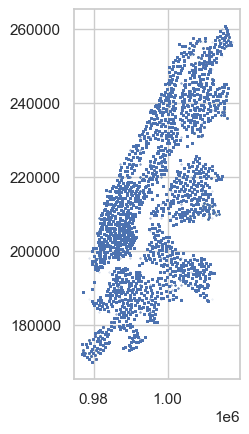

In [68]:
citi_geom_end_study.plot(markersize=0.1,alpha=0.2)

## 3. Results and Discussion


### 3.1 Graphical Representation of Both Services


#### 3.1.1 Geographical Visualization of MTA Stations and Citi Bike Records

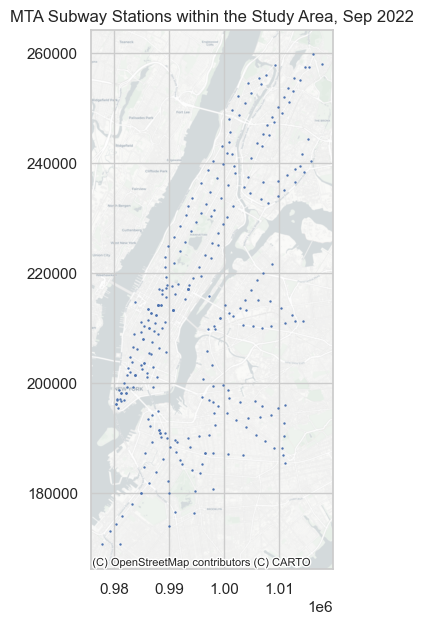

In [69]:
# Plot photograph points
fig1,ax1 = plt.subplots(1,figsize=(7,7))
mta_compressed_geom_study.plot(ax=ax1,markersize=0.5)
ax1.set_title('MTA Subway Stations within the Study Area, Sep 2022')
# Add basemap
ctx.add_basemap(
    ax1, source=ctx.providers.CartoDB.Positron,
    crs="EPSG:2263",
)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

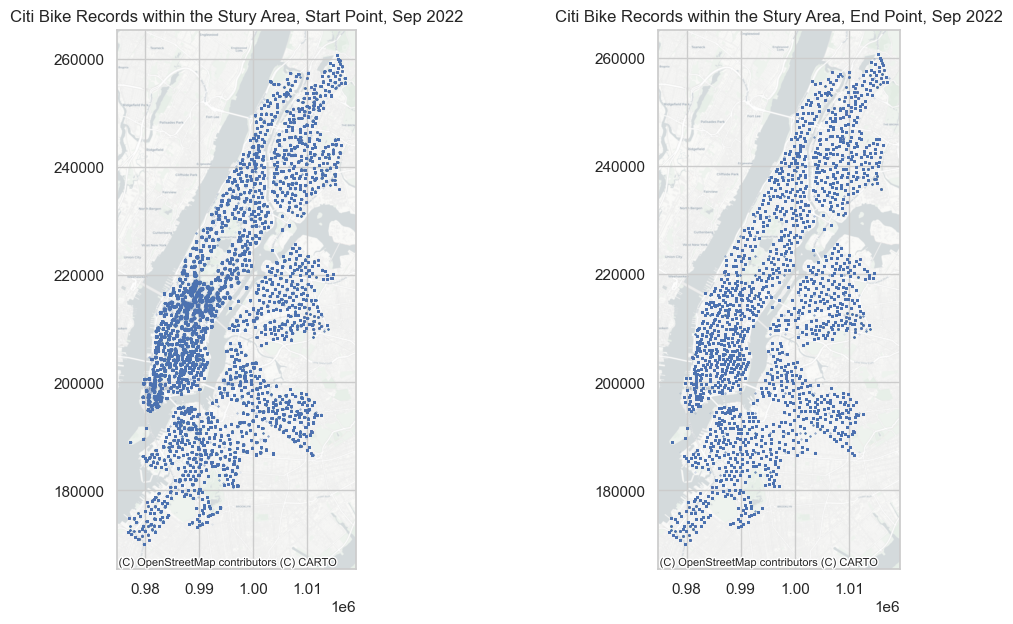

In [70]:
# Plot photograph points
fig2,ax2 = plt.subplots(1,2,figsize=(14,7))
citi_geom_start_study.plot(ax=ax2[0],markersize=0.1,alpha=0.2)
citi_geom_end_study.plot(ax=ax2[1],markersize=0.1,alpha=0.2)
ax2[0].set_title('Citi Bike Records within the Stury Area, Start Point, Sep 2022')
ax2[1].set_title('Citi Bike Records within the Stury Area, End Point, Sep 2022')
# Add basemap
ctx.add_basemap(
    ax2[0], source=ctx.providers.CartoDB.Positron,
    crs="EPSG:2263",
)
ctx.add_basemap(
    ax2[1], source=ctx.providers.CartoDB.Positron,
    crs="EPSG:2263",
)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

#### 3.1.2 MTA Turnstile Counts and Citi Bike Records by Hour

In [71]:
### Citibike Trip Counts
citi_byhour_start = citi_geom_start_study.groupby('start_time').count()
citi_byhour_end = citi_geom_start_study.groupby('end_time').count()
citi_byhour_end.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_timestamp,end_timestamp,duration,start_time,geometry
end_time,,,,,,,,,,,,,,,,,,
0,33095,33095,33095,33095,33095,33095,33057,33057,33095,33095,33095,33095,33095,33095,33095,33095,33095,33095
1,16579,16579,16579,16579,16579,16579,16560,16560,16579,16579,16579,16579,16579,16579,16579,16579,16579,16579
2,9559,9559,9559,9559,9559,9559,9540,9540,9559,9559,9559,9559,9559,9559,9559,9559,9559,9559
3,6151,6151,6151,6151,6151,6151,6141,6141,6151,6151,6151,6151,6151,6151,6151,6151,6151,6151
4,5695,5695,5695,5695,5695,5695,5687,5687,5695,5695,5695,5695,5695,5695,5695,5695,5695,5695


In [72]:
citi_byhour_start = citi_byhour_start[['ride_id']]/30
citi_byhour_start = citi_byhour_start.rename(columns={'ride_id': 'ride_count'})
citi_byhour_end = citi_byhour_end[['ride_id']]/30
citi_byhour_end = citi_byhour_end.rename(columns={'ride_id': 'ride_count'})
citi_byhour_end.head()

,ride_count
end_time,
0,1103.166667
1,552.633333
2,318.633333
3,205.033333
4,189.833333


In [73]:
mta_compressed_geom_study_byhour_raw = mta_compressed_geom_study.sum()
mta_compressed_geom_study_byhour = pd.DataFrame(data=None)

for i in range(0,24):
    mta_compressed_geom_study_byhour.loc['Entries',i] = mta_compressed_geom_study_byhour_raw['entries_'+str(i)]
    mta_compressed_geom_study_byhour.loc['Exits',i] = mta_compressed_geom_study_byhour_raw['exits_'+str(i)]

In [74]:
mta_compressed_geom_study_byhour

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Entries,10437.841667,4491.475000,3982.158333,3983.058333,24305.175000,44763.591667,46439.108333,46624.733333,61256.358333,58282.466667,...,80150.491667,80712.925,96184.425000,91225.216667,89928.450000,89227.166667,48468.175,27530.258333,26274.016667,25035.850000
Exits,20481.833333,9312.691667,9043.025000,9160.250000,35506.333333,69291.200000,73798.066667,75174.783333,117625.116667,117378.783333,...,102716.508333,102841.650,126943.816667,129171.725000,127491.608333,127019.508333,75178.150,47517.683333,45789.650000,43752.266667


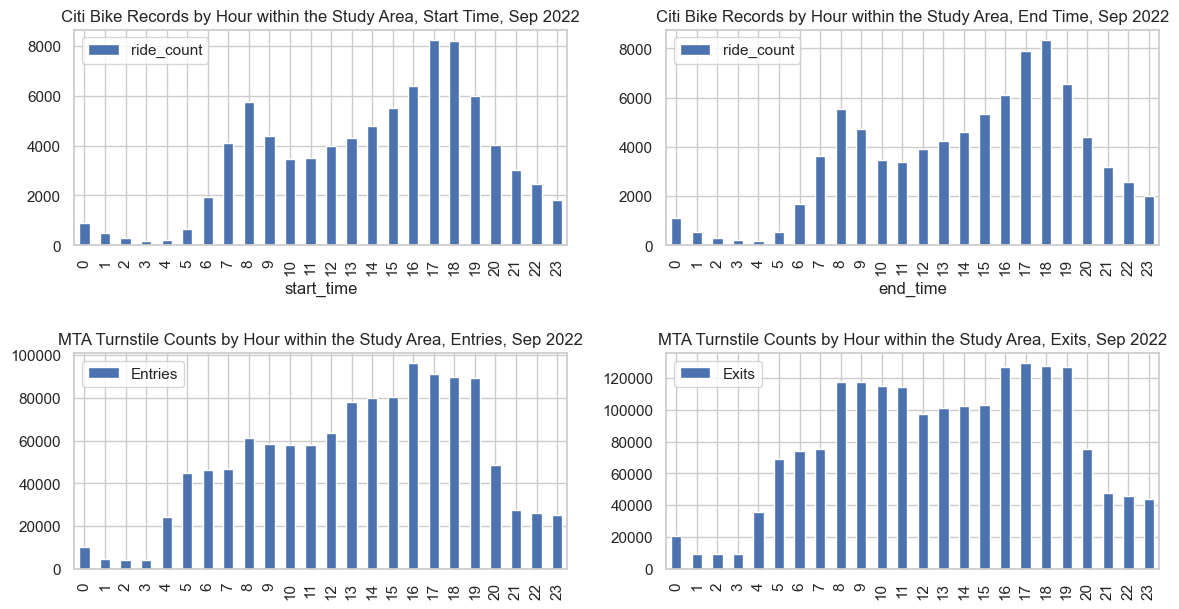

In [75]:
fig3,ax3 = plt.subplots(2,2,figsize=(14,7))
citi_byhour_start.plot(kind='bar',ax=ax3[0][0],legend=True)
citi_byhour_end.plot(kind='bar',ax=ax3[0][1],legend=True)
mta_compressed_geom_study_byhour.loc['Entries'].plot(kind='bar',ax=ax3[1][0],legend=True)
mta_compressed_geom_study_byhour.loc['Exits'].plot(kind='bar',ax=ax3[1][1],legend=True)
ax3[0][0].set_title('Citi Bike Records by Hour within the Study Area, Start Time, Sep 2022')
ax3[0][1].set_title('Citi Bike Records by Hour within the Study Area, End Time, Sep 2022')
ax3[1][0].set_title('MTA Turnstile Counts by Hour within the Study Area, Entries, Sep 2022')
ax3[1][1].set_title('MTA Turnstile Counts by Hour within the Study Area, Exits, Sep 2022')
plt.subplots_adjust(wspace=0.2 , hspace=0.5)

Noticing that MTA entries and exits doesn't match. By viewing the MTA Developer Resources Forum (https://groups.google.com/g/mtadeveloperresources/c/UaMktsBMjX8), we find that the entries doesn't include OMNY tap records. Hence, we should use the exit records to represent the MTA usage situation.

And, to make things simple, we will use End Time (one reason is we are also using exit records for subway) as an ‘anchor point' for all Citi Bike records. For example, after we filter the trips using our three-tier (two-tier in actual practice) filter, we will catogrize them into 24 hours by their End Time and calculate the substitution rate in every hour.

So the graph for comparison in this step will be:

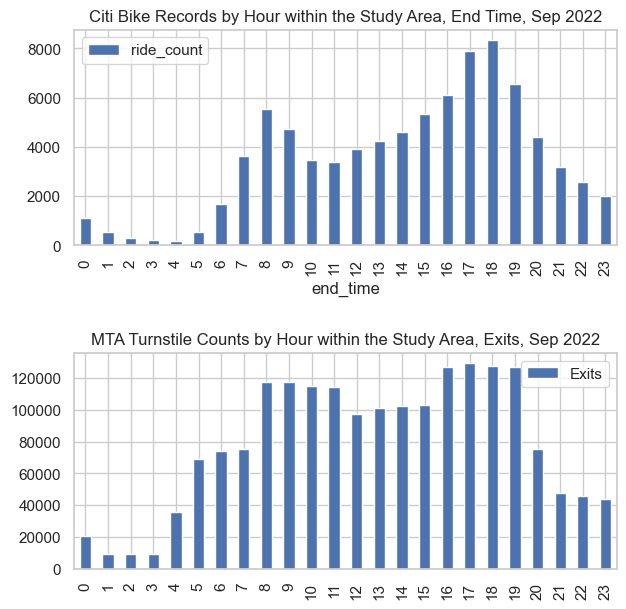

In [76]:
fig4,ax4 = plt.subplots(2,1,figsize=(7,7))
citi_byhour_end.plot(kind='bar',ax=ax4[0],legend=True)
mta_compressed_geom_study_byhour.loc['Exits'].plot(kind='bar',ax=ax4[1],legend=True)
ax4[0].set_title('Citi Bike Records by Hour within the Study Area, End Time, Sep 2022')
ax4[1].set_title('MTA Turnstile Counts by Hour within the Study Area, Exits, Sep 2022')
plt.subplots_adjust(wspace=0.2 , hspace=0.5)

### 3.2 Applying the Filter

#### 3.2.1 First Layer: Transit Coverage

##### a. Create the Buffer Zone of MTA Subway Stations

In [77]:
### Make the geometries
### Since we used 1320 feet for walk distance (1/4 mile)
mta_compressed_geom_study_buffer_geom = mta_compressed_geom_study['geometry'].buffer(1320)

### Second, we keep the CRS
mta_compressed_geom_study_buffer_crs = mta_compressed_geom_study.crs

### Now, let's put it all together using the GeoDataFrame constructor
mta_compressed_geom_study_buffer = gpd.GeoDataFrame(mta_compressed_geom_study.copy(), crs=mta_compressed_geom_study_buffer_crs, geometry=mta_compressed_geom_study_buffer_geom)

<AxesSubplot: >

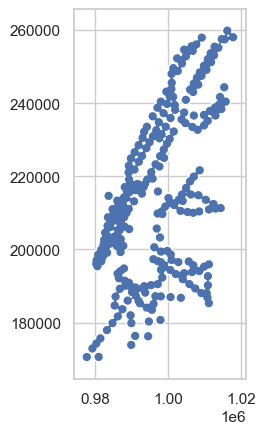

In [78]:
### We dissolve the buffer
mta_compressed_geom_study_buffer = mta_compressed_geom_study_buffer.dissolve()
mta_compressed_geom_study_buffer = mta_compressed_geom_study_buffer.drop(columns=['index_right'])
mta_compressed_geom_study_buffer.plot()

##### b. Filter the Citi Bike Trips with Both Ends within the Buffer Zone

In [79]:
### First filter one end
citi_geom_start_study_inbuffer = gpd.sjoin(citi_geom_start_study, mta_compressed_geom_study_buffer, predicate='within')
citi_geom_end_study_inbuffer = gpd.sjoin(citi_geom_end_study, mta_compressed_geom_study_buffer, predicate='within')

In [80]:
### Then filter another end
citi_geom_start_study_inbuffer = citi_geom_start_study_inbuffer[citi_geom_start_study_inbuffer['ride_id'].isin(citi_geom_end_study_inbuffer['ride_id'])]
citi_geom_end_study_inbuffer = citi_geom_end_study_inbuffer[citi_geom_end_study_inbuffer['ride_id'].isin(citi_geom_start_study_inbuffer['ride_id'])]

In [81]:
### Take a look ate the records
citi_geom_start_study_inbuffer

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,exits_20,entries_21,exits_21,entries_22,exits_22,remote,complex_id,Complex ID,GTFS Latitude,GTFS Longitude
3,757BFFFB009E8D21,classic_bike,2022-09-16 18:46:33,2022-09-16 18:52:42,48 St & 5 Ave,3202.06,36 St & 4 Ave,3420.01,40.646351,-74.009271,...,518.625,176.175,518.625,176.175,518.625,R248,119.0,119.0,40.730953,-73.981628
7,A577D7888E71BDAB,classic_bike,2022-09-14 16:25:45,2022-09-14 16:44:57,49 Ave & 21 St,6128.04,Crescent St & 30 Ave,6958.06,40.742520,-73.948852,...,518.625,176.175,518.625,176.175,518.625,R248,119.0,119.0,40.730953,-73.981628
8,14F4028056EF771B,classic_bike,2022-09-08 08:17:02,2022-09-08 08:29:29,6 Ave & W 34 St,6364.10,E 53 St & Lexington Ave,6617.09,40.749640,-73.988050,...,518.625,176.175,518.625,176.175,518.625,R248,119.0,119.0,40.730953,-73.981628
10,74A9BC718594EEBD,classic_bike,2022-09-14 08:54:41,2022-09-14 09:10:15,Cleveland Pl & Spring St,5492.05,E 33 St & 5 Ave,6322.01,40.722104,-73.997249,...,518.625,176.175,518.625,176.175,518.625,R248,119.0,119.0,40.730953,-73.981628
11,4BF9A6C8A71B6EF5,classic_bike,2022-09-12 16:06:24,2022-09-12 16:18:14,4 Ave & 3 St,4028.04,Hanson Pl & Ashland Pl,4395.07,40.673746,-73.985649,...,518.625,176.175,518.625,176.175,518.625,R248,119.0,119.0,40.730953,-73.981628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3507114,8CC5A9E8BAD5E522,classic_bike,2022-09-22 17:38:00,2022-09-22 17:57:50,Ashland Pl & Dekalb Ave,4513.09,West Drive & Prospect Park West,3651.04,40.690065,-73.978776,...,518.625,176.175,518.625,176.175,518.625,R248,119.0,119.0,40.730953,-73.981628
3507116,0DB417D059C62F11,classic_bike,2022-09-23 19:29:53,2022-09-23 19:50:13,W 100 St & Manhattan Ave,7538.14,W 47 St & 9 Ave,6786.02,40.795000,-73.964500,...,518.625,176.175,518.625,176.175,518.625,R248,119.0,119.0,40.730953,-73.981628
3507118,991C19F915D01AD4,classic_bike,2022-09-01 09:19:01,2022-09-01 09:42:30,N 15 St & Wythe Ave,5520.09,Lafayette St & E 8 St,5788.13,40.724055,-73.955736,...,518.625,176.175,518.625,176.175,518.625,R248,119.0,119.0,40.730953,-73.981628
3507120,FA6C91DFB348AABA,classic_bike,2022-09-02 15:09:15,2022-09-02 15:11:48,Southern Blvd & E 172 St,8129.02,Freeman St & Southern Blvd,8060.01,40.834124,-73.889550,...,518.625,176.175,518.625,176.175,518.625,R248,119.0,119.0,40.730953,-73.981628


In [82]:
### Count the records into 24 hours by End Time
citi_byhour_end_filtered1 = citi_geom_start_study_inbuffer.groupby('end_time').count()
citi_byhour_end_filtered1.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,exits_20,entries_21,exits_21,entries_22,exits_22,remote,complex_id,Complex ID,GTFS Latitude,GTFS Longitude
end_time,,,,,,,,,,,,,,,,,,,,,
0,16916,16916,16916,16916,16916,16916,16901,16901,16916,16916,...,16916,16916,16916,16916,16916,16916,16916,16916,16916,16916
1,8594,8594,8594,8594,8594,8594,8582,8582,8594,8594,...,8594,8594,8594,8594,8594,8594,8594,8594,8594,8594
2,5024,5024,5024,5024,5024,5024,5015,5015,5024,5024,...,5024,5024,5024,5024,5024,5024,5024,5024,5024,5024
3,3155,3155,3155,3155,3155,3155,3149,3149,3155,3155,...,3155,3155,3155,3155,3155,3155,3155,3155,3155,3155
4,2839,2839,2839,2839,2839,2839,2837,2837,2839,2839,...,2839,2839,2839,2839,2839,2839,2839,2839,2839,2839


In [83]:
citi_byhour_end_filtered1 = citi_byhour_end_filtered1[['ride_id']]/30
citi_byhour_end_filtered1 = citi_byhour_end_filtered1.rename(columns={'ride_id': 'ride_count'})
citi_byhour_end_filtered1.head()

,ride_count
end_time,
0,563.866667
1,286.466667
2,167.466667
3,105.166667
4,94.633333


In [84]:
### Calculate the substitution rate
citi_byhour_end['sub_rate_1'] = citi_byhour_end_filtered1['ride_count'] / citi_byhour_end['ride_count']
citi_byhour_end

,ride_count,sub_rate_1
end_time,,
0,1103.166667,0.511135
1,552.633333,0.518367
2,318.633333,0.525578
3,205.033333,0.512925
4,189.833333,0.498507
5,530.933333,0.494726
6,1666.966667,0.469915
7,3629.733333,0.478851
8,5528.700000,0.498345


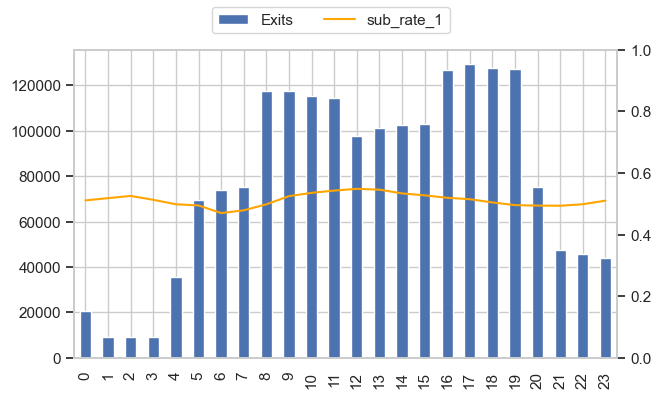

In [85]:
fig5,ax5 = plt.subplots(figsize=(7,4))
ax6=ax5.twinx()
ax6.set_ylim(0,1)
mta_compressed_geom_study_byhour.loc['Exits'].plot(kind='bar',ax=ax5,legend=False)
citi_byhour_end['sub_rate_1'].plot(ax=ax6,legend=False,grid=False,color='orange')
fig5.legend(loc="upper center", ncol=2)

#### 3.2.2 Second Layer: Travel Time Difference

##### a. Importing Transit Time NYC

In [86]:
### Thannks to Transit Time NYC, we can have a easy way to get the estimated subway travel time of any two points in NYC.
### Credit: https://project.wnyc.org/transit-time/
### The following steps will help us import the Transit Time NYC data into our project, incuding a hexagon NYC map and corresponding json files.
mta_time_geo = gpd.read_file('Data/MTA/Travel_Time/nyc_hexes_2000ft_4326.zip')
mta_time_geo = mta_time_geo.to_crs('2263')

<AxesSubplot: >

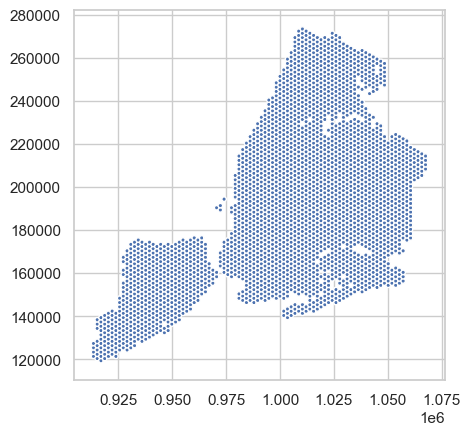

In [87]:
mta_time_geo.plot()

In [88]:
mta_time = pd.DataFrame()
for i in range(1,2931):
    mta_time[i] = pd.read_json("Data/MTA/Travel_Time/json/"+str(i)+".json",orient='index')
mta_time = mta_time.sort_index()

In [89]:
mta_time

,1,2,3,4,5,6,7,8,9,10,...,2921,2922,2923,2924,2925,2926,2927,2928,2929,2930
1,0,9,9999,9999,7,9,15,23,24,63,...,730,730,733,735,739,748,735,741,743,747
2,9,0,9999,9999,17,10,9,16,17,56,...,723,722,726,728,732,741,728,734,735,740
3,9999,9999,0,2,9999,9999,9999,9999,9999,9999,...,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999
4,9999,9999,2,0,9999,9999,9999,9999,9999,9999,...,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999
5,7,17,9999,9999,0,9,18,29,30,68,...,736,735,738,741,745,754,740,747,748,753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2926,748,741,9999,9999,754,745,736,735,731,770,...,44,35,26,18,9,0,28,23,14,8
2927,735,728,9999,9999,740,731,723,722,718,756,...,19,10,10,15,22,28,0,9,18,25
2928,741,734,9999,9999,747,738,729,728,724,763,...,25,16,9,11,17,23,9,0,10,19
2929,743,735,9999,9999,748,739,731,730,726,764,...,33,24,17,9,10,14,18,10,0,10


In [90]:
### Drop unnecessary columns before next step
citi_geom_start_study_inbuffer_intime_raw = citi_geom_start_study_inbuffer.drop(columns=['index_right'])
citi_geom_end_study_inbuffer_intime_raw = citi_geom_end_study_inbuffer.drop(columns=['index_right'])

In [91]:
### In this step, we add a row to the results of our filter 1, indicating which hexagon the start and end point of the orders are in.
citi_geom_start_study_inbuffer_intime_raw = gpd.sjoin(citi_geom_start_study_inbuffer_intime_raw, mta_time_geo[['geometry']], how='left', op='intersects')
citi_geom_end_study_inbuffer_intime_raw = gpd.sjoin(citi_geom_end_study_inbuffer_intime_raw, mta_time_geo[['geometry']], how='left', op='intersects')

<AxesSubplot: >

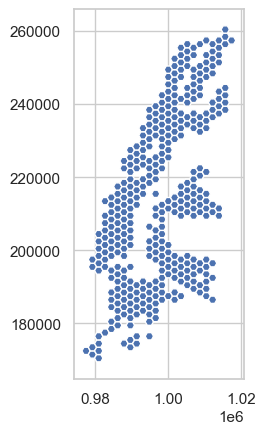

In [92]:
### E.g.: Here this maps shows those hexagons which contains the end point of our filtered orders after filter 1.
mta_time_geo[mta_time_geo.index.isin(citi_geom_end_study_inbuffer_intime_raw['index_right'].unique())].plot()

##### b. Calculate Subway Travel Time for Every Citi Bike Record

In [93]:
### Add a column to the filter 1 result, representing the anticipated subway travel time of every Citi Bike order using the same start and end point (in minutes, by the Transit Time NYC data)
for i in citi_geom_end_study_inbuffer_intime_raw.index:
    citi_geom_end_study_inbuffer_intime_raw.loc[i,'MTA_time'] = mta_time.loc[citi_geom_start_study_inbuffer_intime_raw.loc[i,'index_right']+1,citi_geom_end_study_inbuffer_intime_raw.loc[i,'index_right']+1]

In [94]:
### We calculated the anticipated difference between two ways of transportation: the Citi Bike and estimated subway travel (in seconds)
citi_geom_end_study_inbuffer_intime_raw['time_difference'] = (citi_geom_end_study_inbuffer_intime_raw['MTA_time'] * 60) - citi_geom_end_study_inbuffer_intime_raw['duration']

##### c. Perform the Filter

In [95]:
### In the following steps we will perform the filter 2.
### In the model, we have a variable T as the threshold of filter 2:
### all orders with the duration difference of two ways of transportation no larger than T will be considered as substitutional relationship, as customers can choose between
### them without the potential of saving too much time using either of both (in which situation it will be considered as complementary relationship).
### Here we will try T in (1,2,....,30) to find the best value.
citi_geom_end_study_inbuffer_intime_try = pd.DataFrame()
for n in range(-1,30):
    citi_geom_end_study_inbuffer_intime_try.loc[n+1,'sub_rate_2'] = (abs(citi_geom_end_study_inbuffer_intime_raw['time_difference'])<=((n+1)*60)).sum() / citi_geom_end_study['ride_id'].count()

<AxesSubplot: >

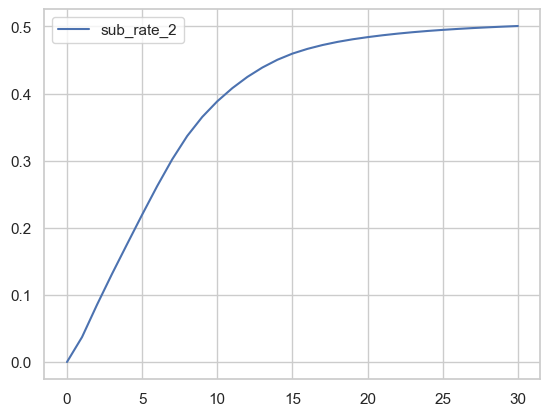

In [96]:
### Show the result of our tryouts
citi_geom_end_study_inbuffer_intime_try.plot()

In [97]:
### We decide to use T=7(min) as our threshold. Here we perform the filter 2.
citi_geom_end_study_inbuffer_intime_7 = citi_geom_end_study_inbuffer_intime_raw[abs(citi_geom_end_study_inbuffer_intime_raw['time_difference'])<=(7*60)]

In [98]:
### Count the records after filter 2 into 24 hours by End Time
citi_byhour_end_filtered2 = citi_geom_end_study_inbuffer_intime_7.groupby('end_time').count()
citi_byhour_end_filtered2.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,entries_22,exits_22,remote,complex_id,Complex ID,GTFS Latitude,GTFS Longitude,index_right,MTA_time,time_difference
end_time,,,,,,,,,,,,,,,,,,,,,
0,8798,8798,8798,8798,8798,8798,8795,8795,8798,8798,...,8798,8798,8798,8798,8798,8798,8798,8798,8798,8798
1,4375,4375,4375,4375,4375,4375,4375,4375,4375,4375,...,4375,4375,4375,4375,4375,4375,4375,4375,4375,4375
2,2573,2573,2573,2573,2573,2573,2572,2572,2573,2573,...,2573,2573,2573,2573,2573,2573,2573,2573,2573,2573
3,1564,1564,1564,1564,1564,1564,1564,1564,1564,1564,...,1564,1564,1564,1564,1564,1564,1564,1564,1564,1564
4,1366,1366,1366,1366,1366,1366,1365,1365,1366,1366,...,1366,1366,1366,1366,1366,1366,1366,1366,1366,1366


In [99]:
### Calculate the average of one month into one day and rename the column
citi_byhour_end_filtered2 = citi_byhour_end_filtered2[['ride_id']]/30
citi_byhour_end_filtered2 = citi_byhour_end_filtered2.rename(columns={'ride_id': 'ride_count'})
citi_byhour_end_filtered2.head()

,ride_count
end_time,
0,293.266667
1,145.833333
2,85.766667
3,52.133333
4,45.533333


In [100]:
### Calculate the substitution rate after filter 2
citi_byhour_end['sub_rate_2'] = citi_byhour_end_filtered2['ride_count'] / citi_byhour_end['ride_count']
citi_byhour_end.head()

,ride_count,sub_rate_1,sub_rate_2
end_time,,,
0,1103.166667,0.511135,0.265841
1,552.633333,0.518367,0.263888
2,318.633333,0.525578,0.269170
3,205.033333,0.512925,0.254268
4,189.833333,0.498507,0.239860


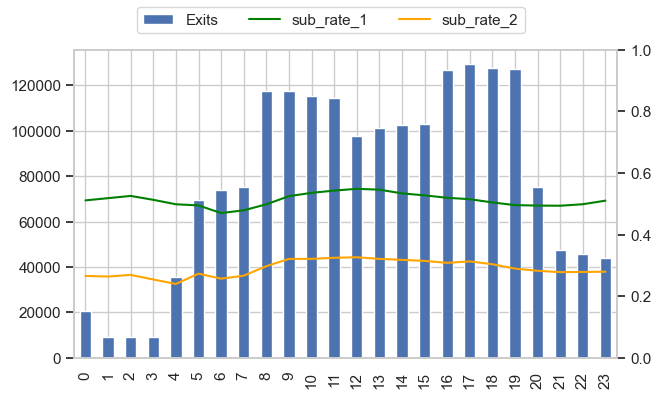

In [101]:
### An visualization of the result
fig7,ax7 = plt.subplots(figsize=(7,4))
ax8=ax7.twinx()
ax8.set_ylim(0,1)
mta_compressed_geom_study_byhour.loc['Exits'].plot(kind='bar',ax=ax7,legend=False)
citi_byhour_end['sub_rate_1'].plot(ax=ax8,legend=False,grid=False,color='green')
citi_byhour_end['sub_rate_2'].plot(ax=ax8,legend=False,grid=False,color='orange')
fig7.legend(loc="upper center", ncol=3)

### 3.3 Spatiotemporal Variation of the Relationship


#### 3.3.1 Calculate the Substitution Rate of Each Cell of the Fishnet

In [272]:
### Now it's time to classify all the order records before and after both filters into our pre-prepared fishnet, to calculate the substitution rate
### The first step is to calculate the number of original records which fall in every cell of the fishnet
fishnet_ordercount_end = gpd.sjoin(fishnet_crop, 
                            citi_geom_end_study, 
                            how="left", 
                            op='contains')

In [273]:
fishnet_ordercount_end['id'] = fishnet_ordercount_end.index
fishnet_ordercount_end = fishnet_ordercount_end.groupby('id')[['ride_id']].count()
fishnet_ordercount_end = fishnet_ordercount_end.rename(columns={'ride_id':'total_order_end'})

In [274]:
soci_final = soci_final.merge(fishnet_ordercount_end,
                                left_index=True,
                                right_on='id',how='left')

In [276]:
### The second step is to calculate the number of records after two filters which fall in every cell of the fishnet
citi_geom_end_study_inbuffer_intime_7 = citi_geom_end_study_inbuffer_intime_7.drop(columns=['index_right'])
fishnet_ordercount_end_filtered = gpd.sjoin(fishnet_crop, 
                            citi_geom_end_study_inbuffer_intime_7, 
                            how="left", 
                            op='contains')

In [277]:
fishnet_ordercount_end_filtered['id'] = fishnet_ordercount_end_filtered.index
fishnet_ordercount_end_filtered = fishnet_ordercount_end_filtered.groupby('id')[['ride_id']].count()
fishnet_ordercount_end_filtered = fishnet_ordercount_end_filtered.rename(columns={'ride_id':'filtered_order_end'})

In [278]:
soci_final = soci_final.merge(fishnet_ordercount_end_filtered,
                                left_index=True,
                                right_on='id',how='left')

In [279]:
### the third step is to find the ratio of filtered orders to all the original orders, as the substitution rate of every cell
soci_final['sub_rate_end'] = soci_final['filtered_order_end'] / soci_final['total_order_end']

Text(0.5, 1.0, 'NYC Citi Bike to Subway Substitution Rate')

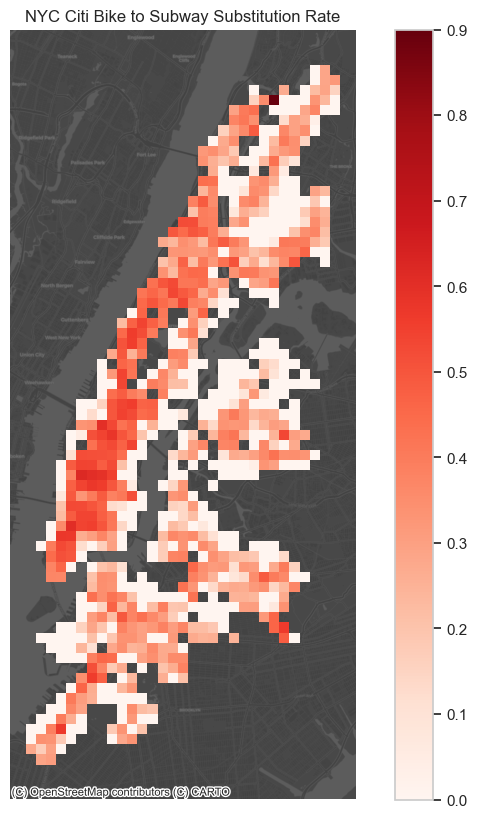

In [342]:
### Have a look at these cells
### NOTICE we use end location to locte the orders, which is because we are also using exits for subways, and end time for categorizing orders into 24 hours in previous steps.
fig9,ax9 = plt.subplots(figsize=(10,10))
soci_final.plot(ax=ax9,column='sub_rate_end',legend=True,edgecolor='none',cmap='Reds')
ctx.add_basemap(ax=ax9,source=ctx.providers.CartoDB.DarkMatter,crs=soci_final.crs,alpha=0.75)
ax9.set_axis_off()
plt.title('NYC Citi Bike to Subway Substitution Rate')

In [281]:
### Remove the cells which has no data
soci_final = soci_final[soci_final['sub_rate_end'].isna()==False]

### 3.4 Impacting Factors of the Relationship

In the PLUTO dataset, we have the following socio-economic fators (the sum of all records in the coorsponding cell):

|PLUTO Factor|Meaning|
|---|---|
|LotArea|Lot Area|
|BldgArea|Total Building Area|
|ComArea|Commercial Area|
|ResArea|Residential Area|
|OfficeArea|Office Area|
|RetailArea|Retail Area|
|GarageArea|Garage Area|
|StrgeArea|Storage Area|
|FactryArea|Factory Area|
|OtherArea|Other Area|
|AssessLand|Assessed Land Value|
|AssessTot|Assessed Total Value|
|ExemptTot|Exampt Total Value|

Noticing that:

1. Total Building Area = Commercial Area + Residential Area

2. Residential Area = Office Area + Retail Area + Garage Area + Storage Area + Factory Area + Other Area

Therefore for the final regression, we will choose these factors (some from calculation):

|PLUTO Factor Chosen|Meaning|
|---|---|
|BldgArea|Total Building Area|
|ResPerc|Residential / Total Building Area|
|OfficePerc|Office / Total Building Area|
|RetailPerc|Retail / Total Building Area|
|AssessTot|Assessed Total Value|

In [284]:
soci_final['ResPerc'] = soci_final['ResArea'] / soci_final['BldgArea']
soci_final['OfficePerc'] = soci_final['OfficeArea'] / soci_final['BldgArea']
soci_final['RetailPerc'] = soci_final['RetailArea'] / soci_final['BldgArea']

In [285]:
soci_final = soci_final[soci_final['ResPerc'].isna()==False]
soci_final = soci_final[soci_final['OfficePerc'].isna()==False]
soci_final = soci_final[soci_final['RetailPerc'].isna()==False]

Here we need to add more factors into the model, they are:
|Other Factors|Meaning|
|---|---|
|MTAStation|Number of Subway Stations in the Cell (Exits)|
|CitiStation|Number of Citi Bike Stations in the Cell (Ends)|
|CitiAvgDuration|Average Citi Bike Order Duration in the Cell (Ends)|

In [ ]:
### Removing Unnecessary Column for Next Step
mta_compressed_geom_study = mta_compressed_geom_study.drop(columns=['index_right'])

In [287]:
### To count MTA Transits in each cell
mta_count_cell = gpd.sjoin(soci_final, 
                            mta_compressed_geom_study, 
                            how="left", 
                            op='contains')

In [288]:
mta_count_cell = mta_count_cell.groupby('id').sum()

In [289]:
mta_count_cell['MTATransit'] = 0
for i in range(0,24):
    mta_count_cell['MTATransit'] += mta_count_cell['exits_'+str(i)]

In [290]:
soci_final =  soci_final.merge(mta_count_cell['MTATransit'],left_index=True,right_on='id',how='left')

In [307]:
### To count Citi Bike Transits in each cell
soci_final['CitiTransit'] = soci_final['total_order_end']

In [292]:
### To add average Citi Bike Transits Duration in each cell
fishnet_order_avgtime = gpd.sjoin(soci_final, 
                            citi_geom_end_study, 
                            how="left", 
                            op='contains')
fishnet_order_avgtime = fishnet_order_avgtime.groupby('id')[['duration']].mean()
fishnet_order_avgtime = fishnet_order_avgtime.rename(columns={'duration':'CitiAvgDuration'})
soci_final = soci_final.merge(fishnet_order_avgtime,
                                left_index=True,
                                right_on='id',how='left')

In [293]:
### To count MTA Stations in each cell
mta_station_count_cell = gpd.sjoin(soci_final, 
                            mta_compressed_geom_study, 
                            how="left", 
                            op='contains')

In [294]:
mta_station_count_cell = mta_station_count_cell.groupby('id').count()

In [295]:
mta_station_count_cell = mta_station_count_cell[['Unit']]
mta_station_count_cell = mta_station_count_cell.rename(columns={'Unit':'MTAStation'})

In [296]:
soci_final =  soci_final.merge(mta_station_count_cell['MTAStation'],left_index=True,right_on='id',how='left')

In [297]:
### To count Citi Bike Stations in each cell
citi_station_count_cell = gpd.sjoin(soci_final, 
                            citi_stations_geom, 
                            how="left", 
                            op='contains')

In [298]:
citi_station_count_cell = citi_station_count_cell.groupby('id').count()

In [299]:
citi_station_count_cell = citi_station_count_cell[['station_name']]
citi_station_count_cell = citi_station_count_cell.rename(columns={'station_name':'CitiStation'})

In [300]:
soci_final =  soci_final.merge(citi_station_count_cell['CitiStation'],left_index=True,right_on='id',how='left')

In [308]:
### We now have all the columns for the OLS model!
soci_final.columns

Index(['geometry', 'LotArea', 'BldgArea', 'ComArea', 'ResArea', 'OfficeArea',
       'RetailArea', 'GarageArea', 'StrgeArea', 'FactryArea', 'OtherArea',
       'NumBldgs', 'NumFloors', 'UnitsRes', 'UnitsTotal', 'AssessLand',
       'AssessTot', 'ExemptTot', 'total_order_end', 'filtered_order_end',
       'sub_rate_end', 'ResPerc', 'OfficePerc', 'RetailPerc', 'MTATransit',
       'CitiAvgDuration', 'MTAStation', 'CitiStation', 'CitiTransit'],
      dtype='object')

#### 3.4.1 Simple OLS Model

##### a. Model

In [303]:
soci_final_new = soci_final

In [309]:
soci_final_new.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 883 entries, 35 to 2307
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   geometry            883 non-null    geometry
 1   LotArea             883 non-null    float64 
 2   BldgArea            883 non-null    float64 
 3   ComArea             883 non-null    float64 
 4   ResArea             883 non-null    float64 
 5   OfficeArea          883 non-null    float64 
 6   RetailArea          883 non-null    float64 
 7   GarageArea          883 non-null    float64 
 8   StrgeArea           883 non-null    float64 
 9   FactryArea          883 non-null    float64 
 10  OtherArea           883 non-null    float64 
 11  NumBldgs            883 non-null    float64 
 12  NumFloors           883 non-null    float64 
 13  UnitsRes            883 non-null    float64 
 14  UnitsTotal          883 non-null    float64 
 15  AssessLand          883 non-nu

In [319]:
list_1 = ['BldgArea','ResPerc','OfficePerc','RetailPerc','AssessTot','MTAStation','CitiStation','CitiAvgDuration']
X = soci_final_new
y = soci_final_new['sub_rate_end']
y = y[X.index]

In [320]:
# Fit OLS model
m1 = spreg.OLS(
    # Dependent variable
    y.values,
    # Independent variables
    X[list_1].values,
    # Dependent variable name
    name_y="sub_rate_end",
    # Independent variable name
    name_x=list_1,
)

In [321]:
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :sub_rate_end                Number of Observations:         883
Mean dependent var  :      0.2190                Number of Variables   :           9
S.D. dependent var  :      0.1881                Degrees of Freedom    :         874
R-squared           :      0.3064
Adjusted R-squared  :      0.3001
Sum squared residual:      21.632                F-statistic           :     48.2727
Sigma-square        :       0.025                Prob(F-statistic)     :   1.467e-64
S.E. of regression  :       0.157                Log likelihood        :     384.666
Sigma-square ML     :       0.024                Akaike info criterion :    -751.332
S.E of regression ML:      0.1565                Schwarz criterion     :    -708.282

-----------------------------------------------------------------------------

The R-squared is 0.3064, indicating that this model explains about 30.64% of the variance in the dependent variable. The F-statistic is 48.2727 and its corresponding p-value is almost 0, which suggests that the model as a whole is significant.

From this result, the variables BldgArea, ResPerc, RetailPerc, MTAStation, CitiAvgDuration have p-values less than 0.05, indicating that they are significant in the model. Other variables, such as OfficePerc, AssessTot, and CitiStation, have p-values greater than 0.05, indicating that they are not significantly associated with the dependent variable in this model.

The Jarque-Bera test has a p-value of 0.0002, less than 0.05, so we reject the null hypothesis and believe that the residuals are not normally distributed. The p-values for both the Breusch-Pagan test and the Koenker-Bassett test are close to 0, indicating that the model suffers from heteroskedasticity.

Therefore, although the model as a whole is significant and some of the predictor variables are significant, there may be some problems with the model, such as residuals not being normally distributed and the presence of heteroskedasticity. These will require further handling.

##### b. Verification
The residuals of OLS helps varifying whether space influence the dependant variable.

In [322]:
X['residual'] = m1.u
X['residual']

id
35      0.114063
36      0.174735
67      0.117290
68     -0.016687
69      0.113829
          ...   
2273   -0.161183
2274    0.119198
2275    0.188972
2306   -0.074802
2307    0.024571
Name: residual, Length: 883, dtype: float64

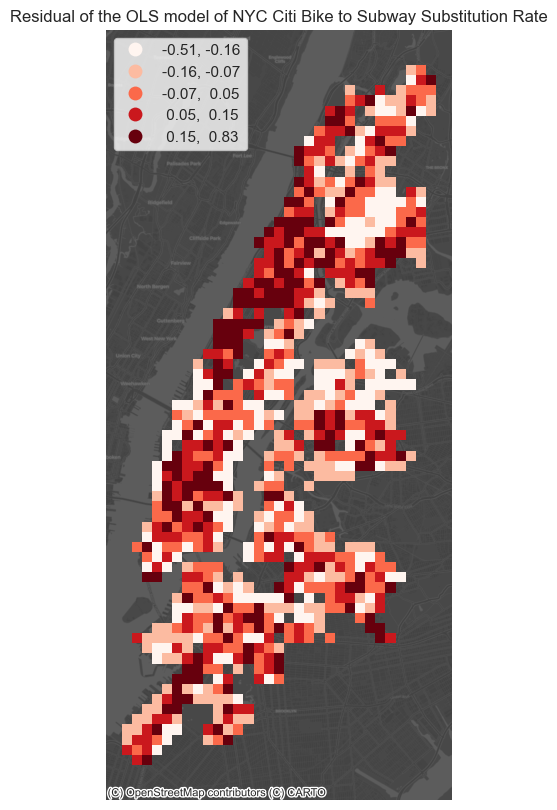

In [341]:
import contextily
ax = (
    X.plot("residual",cmap='Reds',figsize=(10,10),legend=True,edgecolor='none',scheme= 'Quantiles',k=5,legend_kwds={'loc': 'upper left'})
)
plt.title('Residual of the OLS model of NYC Citi Bike to Subway Substitution Rate')
# Add basemap
contextily.add_basemap(ax, source=ctx.providers.CartoDB.DarkMatter, crs=X.crs, alpha=0.75)
# Remove axes
ax.set_axis_off()

##### c. Further Check Using Moran's I

In [370]:
wd = weights.contiguity.Queen.from_dataframe(X)
wd.transform = "R"

In [371]:
moran = esda.moran.Moran(X['residual'], wd)
moran.I

0.33305375863258974

The result indicates a certain degree of positive spatial autocorrelation.

#### 3.4.2 Exogenous Effect -- SLX Model
With spatial clustering exists in the OLS residuals, it implies that adding spatial components to your regression can improve the model performance. Assuming that there is no interaction between the dependent variables and their spatial lags, SLX model can be built using `spreg.OLS` function as the spatial lags of the dependent variables are treated as exogenous variables.这段是复制的 改一下

In [372]:
# Select only columns in `X` containing the keyword `pg_`
lag_variables_used = X[list_1]
        # Compute the spatial lag of each of those variables

wx = lag_variables_used.apply(lambda y: weights.spatial_lag.lag_spatial(wd, y)
        # Rename the spatial lag, adding w_ to the original name
    )
wx = wx.rename(columns=lambda c: "w_"+ c
        # Remove the lag of the binary variable for apartments
    )

In [373]:
wx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 883 entries, 35 to 2307
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   w_BldgArea         883 non-null    float64
 1   w_ResPerc          883 non-null    float64
 2   w_OfficePerc       883 non-null    float64
 3   w_RetailPerc       883 non-null    float64
 4   w_AssessTot        883 non-null    float64
 5   w_MTAStation       883 non-null    float64
 6   w_CitiStation      883 non-null    float64
 7   w_CitiAvgDuration  883 non-null    float64
dtypes: float64(8)
memory usage: 94.4 KB


In [374]:
slx_exog = X[list_1].join(wx)
m2 = spreg.OLS(
    # Dependent variable
    y.values,
    # Independent variables
    slx_exog.values,
    # Dependent variable name
    name_y="sub_rate_end",
    # Independent variables names
    name_x=slx_exog.columns.tolist(),
)

In [375]:
print(m2.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :sub_rate_end                Number of Observations:         883
Mean dependent var  :      0.2190                Number of Variables   :          17
S.D. dependent var  :      0.1881                Degrees of Freedom    :         866
R-squared           :      0.4312
Adjusted R-squared  :      0.4207
Sum squared residual:      17.741                F-statistic           :     41.0315
Sigma-square        :       0.020                Prob(F-statistic)     :    1.35e-94
S.E. of regression  :       0.143                Log likelihood        :     472.214
Sigma-square ML     :       0.020                Akaike info criterion :    -910.427
S.E of regression ML:      0.1417                Schwarz criterion     :    -829.111

-----------------------------------------------------------------------------

R-squared is 0.4312, and Adjusted R-squared is 0.4207 means that the model can explain about 42.07% of the variation in the dependent variable (sub_rate_end).

The p-value of F-statistic is 1.35e-94, which is extremely small, far less than 0.05, indicating the model is statistically significant.

The p-value of the Jarque-Bera test is less than 0.05. We reject the null hypothesis of normally distributed errors. The p-values of both the Breusch-Pagan test and Koenker-Bassett test are less than 0.05. We reject the null hypothesis of homoscedastic errors.

This model is statistically significant, but some coefficients are not statistically significant. 

#### 3.4.3 Spatial Error

In [376]:
# Fit spatial error model with `spreg`
# (GMM estimation allowing for heteroskedasticity)
m3 = spreg.GM_Error_Het(
    # Dependent variable
    y.values,
    # Independent variables
    X[list_1].values,
    # Spatial weights matrix
    w=wd,
    # Dependent variable name
    name_y="sub_rate_end",
    # Independent variables names
    name_x=list_1,
)

In [377]:
print(m3.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES (HET)
---------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :sub_rate_end                Number of Observations:         883
Mean dependent var  :      0.2190                Number of Variables   :           9
S.D. dependent var  :      0.1881                Degrees of Freedom    :         874
Pseudo R-squared    :      0.2991
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       0.1188964       0.0362813       3.2770768       0.0010489
            BldgArea       0.0000000       0.0000000       1.2673270       0.20

Pseudo R-squared is 0.2991, indicates that the model can explain approximately 29.91% of the variation in the dependent variable. 

The CONSTANT coefficient 's p-value is 0.0010489, indicating that the intercept is statistically significant, which means the dependent variable equals to 0.1188964 when all independent variables are 0.

The p-value of BldgArea is 0.2050384, greater than 0.05, indicating that we cannot reject the hypothesis that the coefficient is zero.

The coefficients and corresponding p-values for other independent variables can be used to interpret their impact on the dependent variable. RetailPerc, MTAStation, CitiStation, and CitiAvgDuration have coefficients that are statistically significant (p-value less than 0.05).

Lambda has a coefficient of 0.6588851, indicates a strong spatial autocorrelation.

#### 3.4.4 Spatial Lag

In [378]:
# Fit spatial lag model with `spreg`
# (GMM estimation)
m4 = spreg.GM_Lag(
    # Dependent variable
    y.values,
    # Independent variables
    X[list_1].values,
    # Spatial weights matrix
    w=wd,
    # Dependent variable name
    name_y="sub_rate_end",
    # Independent variables names
    name_x=list_1,
)

In [379]:
print(m4.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :sub_rate_end                Number of Observations:         883
Mean dependent var  :      0.2190                Number of Variables   :          10
S.D. dependent var  :      0.1881                Degrees of Freedom    :         873
Pseudo R-squared    :      0.5598
Spatial Pseudo R-squared:  0.0901

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      -0.0240420       0.0227853      -1.0551556       0.2913542
            BldgArea      -0.0000000       0.0000000      -0.0601874       0.9520064
             ResPerc       0.0215100       0.0207563       

Pseudo R-squared is 0.5598, suggests that approximately 55.98% of the variation in the dependent variable (sub_rate_end) can be explained by the independent variables and spatial effects.

Spatial Pseudo R-squared is 0.0901, indicates that around 9.01% of the spatial variation in the dependent variable is accounted for by the spatial lag component.

The p-value for the t-test of CONSTANT (intercept) is 0.2914, indicating that this coefficient is not statistically significant.

The coefficient for BldgArea is -0.0000000, implying that there is no expected effect of BldgArea on the dependent variable. The coefficient is not statistically significant neither (p-value = 0.9520).

RetailPerc, MTAStation, and CitiAvgDuration have statistically significant coefficients, as their p-values are less than 0.05. This suggests that these variables have a significant effect on the dependent variable.

## 4. Conclusion and Future Research

A three-level structure is used in this paper from a geospatial perspective to investigate the categorical substitution and complementary effects of CitiBike on the MTA in New York City. Each user's use of CitiBike is classified as a potential substitution or complementary relationship to MTA based on transit coverage and travel time differences. The findings suggest that CitiBike both substitutes and complements MTA. Without considering travel time differences, the percentage of CitiBikes considered potential substitutes for MTA remained stable at around 50% ratio for each hour of the 24-hour day. When the travel time difference threshold is set at 7 minutes, a steady rate of about 30% ratio of CitiBikes is considered as potential MTA alternatives for each hour of a 24-hour day. The percentage of CitiBikes as MTA alternatives within Manhattan was significantly higher than in other boroughs.

To explore the effects of different factors on the relationship between drops and public transportation, we further investigate the effects of land use, building space, land price, and spatial lag factors on substitution rates. The results of the study show that the substitution rate is spatially autocorrelated. The proportion of retail uses and metro station spatial effects significantly affect the relationship. The impact of residential ratio, office proportion, and land price are smaller.

This study has several limitations that can be further investigated. 1) Coastal and non-coastal regions can be discussed separately in subsequent studies; 2) Considering the uniqueness of Manhattan, the borough can be discussed separately in the next step; 3) Due to the limitation of computing time and configuration, we only capture one month of CitiBike operation data, which may affect the results.

## References
AitBihiOuali, L., & Klingen, J. (2022). Inclusive roads in NYC: Gender differences in responses to cycling infrastructure. *Cities, 127*, 103719. https://doi.org/10.1016/j.cities.2022.103719

*Citi Bike System Data | Citi Bike NYC.* (n.d.). Retrieved March 31, 2023, from https://citibikenyc.com/system-data

Cui, Y., Chen, X., Chen, X., & Zhang, C. (2023). Competition, Integration, or Complementation? Exploring Dock-Based Bike-Sharing in New York City. *The Professional Geographer, 75*(1), 65–75. https://doi.org/10.1080/00330124.2022.2081224

DeMaio, P. (2009). Bike-sharing: History, Impacts, Models of Provision, and Future. *Journal of Public Transportation, 12*(4), 41–56. https://doi.org/10.5038/2375-0901.12.4.3

Faghih-Imani, A., & Eluru, N. (2016). Incorporating the impact of spatio-temporal interactions on bicycle sharing system demand: A case study of New York CitiBike system. *Journal of Transport Geography, 54*, 218–227. https://doi.org/10.1016/j.jtrangeo.2016.06.008

Guo, Y., Yang, L., & Chen, Y. (2022). Bike Share Usage and the Built Environment: A Review. *Frontiers in Public Health, 10*, 848169. https://doi.org/10.3389/fpubh.2022.848169

Hamad, S. Y. Y., Ma, T., & Antoniou, C. (2021). Analysis and Prediction of Bikesharing Traffic Flow – Citi Bike, New York. *2021 7th International Conference on Models and Technologies for Intelligent Transportation Systems (MT-ITS)*, 1–8. https://doi.org/10.1109/MT-ITS49943.2021.9529290

Kong, H., Zhang, X., & Zhao, J. (2020). How does ridesourcing substitute for public transit? A geospatial perspective in Chengdu, China. *Journal of Transport Geography, 86*, 102769. https://doi.org/10.1016/j.jtrangeo.2020.102769

Kranish, C. (2021a, March 22). *Use Weather History with NYC Bike Share Trip Data*. Medium. https://towardsdatascience.com/use-weather-history-with-nyc-bike-share-trip-data-51fcb89297d

Kranish, C. (2021b, March 29). *Reverse Geocoding with NYC Bike Share Data*. Medium. https://towardsdatascience.com/reverse-geocoding-with-nyc-bike-share-data-cdef427987f8

Kranish, C. (2021c, April 4). *Visualizing NYC Bike Share Trips with a Chord Diagram*. Medium. https://towardsdatascience.com/visualizing-nyc-bike-share-trips-with-a-chord-diagram-eb4c8e14366

Kranish, C. (2021d, April 8). *Exploring the Effects of the Pandemic on NYC Bike Share Usage*. Medium. https://towardsdatascience.com/exploring-the-effects-of-the-pandemic-on-nyc-bike-share-usage-ab79f67ac2df

Kranish, C. (2021e, April 9). *Estimating Bike Availability from NYC Bike Share Data*. Medium. https://towardsdatascience.com/estimating-bike-availability-from-nyc-bike-share-data-7cfc4655d5f6

Kranish, C. (2021f, April 13). *Interpolating NYC Bike Share Data to Discover Rebalancing Movements*. Medium. https://towardsdatascience.com/interpolating-nyc-bike-share-data-to-discover-rebalancing-movements-6cf8a80eb902

Kranish, C. (2021g, May 14). *Exploring Bike Share Data*. Medium. https://towardsdatascience.com/exploring-bike-share-data-3e3b2f28760c

Mix, R., Hurtubia, R., & Raveau, S. (2022). Optimal location of bike-sharing stations: A built environment and accessibility approach. *Transportation Research Part A: Policy and Practice, 160*, 126–142. https://doi.org/10.1016/j.tra.2022.03.022

Wang, W. (2016). Forecasting Bike Rental Demand Using New York Citi Bike Data. *Dissertations*. https://arrow.tudublin.ie/scschcomdis/79

Whong, C. (2020, June 19). Taming the MTA’s Unruly Turnstile Data. *Qri.Io*. https://medium.com/qri-io/taming-the-mtas-unruly-turnstile-data-c945f5f96ba0

Xin, R., Ding, L., Ai, B., Yang, M., Zhu, R., Cao, B., & Meng, L. (2023). Geospatial Network Analysis and Origin-Destination Clustering of Bike-Sharing Activities during the COVID-19 Pandemic. *ISPRS International Journal of Geo-Information, 12*(1), Article 1. https://doi.org/10.3390/ijgi12010023

Yamane, T., & Kaneko, S. (2021). Is the younger generation a driving force toward achieving the sustainable development goals? Survey experiments. *Journal of Cleaner Production, 292*, 125932. https://doi.org/10.1016/j.jclepro.2021.125932

Zhang, L., Xiao, Z., Ren, S., Qin, Z., Goh, R. S. M., & Song, J. (2022). Measuring the vulnerability of bike-sharing system. *Transportation Research Part A: Policy and Practice, 163*, 353–369. https://doi.org/10.1016/j.tra.2022.05.019